***ENEL 645 Final Project***

Objective: Develop machine learning techniques to predict load energy prediction based on the load history, weather and calendar paremeters.

Submitted by Group 9 members:
- Mohsen Tavakolian (30138728)
- Masoud Hajian Foroushani (30253439)
- Samuel Bakker (30104958)
- Sherry Gao (10194604)
- Gona Rahmaniani (30225142)

April 1, 2024

####**AESO Regions:**

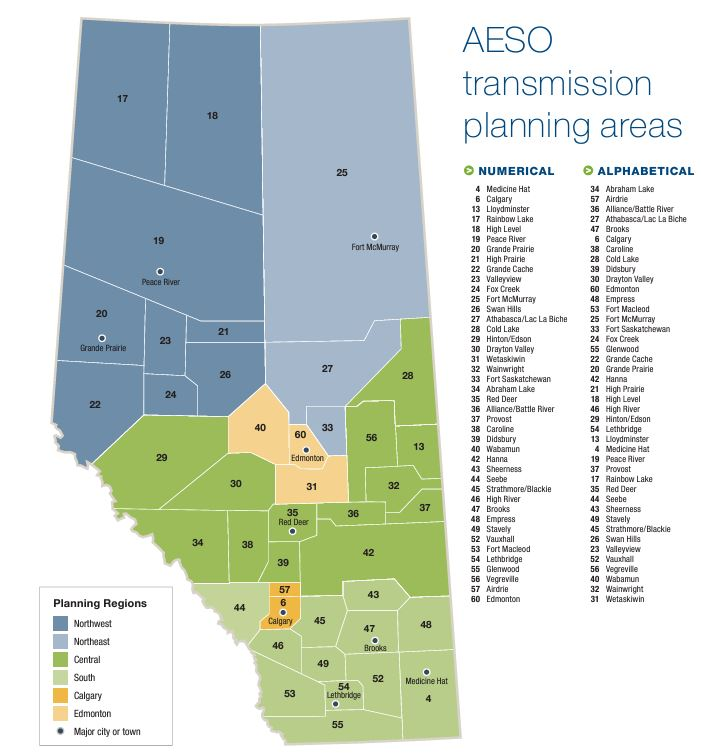

#Description:

Public domain data from AESO have been used (https://www.aeso.ca/market/market-and-system-reporting/data-requests/hourly-load-by-area-and-region/) as the data source for training and prediction. The dataset incorporates energy load hourly data from January 2011 to October 2023 for 42 major cities and regions in Alberta, as shown in the map above.

Special thanks to **weathersource** (https://weathersource.com/products/onpoint-weather/) that provided us with hourly weather data in json format for the period of 2011 to 2023 (with 28 weather features). Special thank to weathersource.com for granting us free access to their valuable data.

#Summary:
In this study, we tried to explore different approaches that could help operators predict the energy load with high and acceptable accuracy for a desired period of time ahead. In a nutshell, we fulfilled these steps:


1.   Data collection and cleansing
2.   Feature engineering and data visualization
3.   Application of several machine learning (ML) techniques, including deterministic and probabilistic methods
4.   Applicability of transfer learning
5.   Choice of best model and overview of future work



**Note: The code has been developed by Google CoLab with the data stored on Drive.**

The first four lines to uninstall numpy, install a specific version of it, and then installation two libraries are a requirement for the last part of our project (probabilistic forecating). Gluonts library has some legacy which is not compatible with updated numpy.

In [ ]:
!pip uninstall numpy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.10/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install numpy==1.23.3

In [ ]:
!pip install gluonts

In [ ]:
!pip install mxnet

In [ ]:
# Commented out. We ran the code on Google Colab. Relevant code and dataset has been pushed to git repo.

# # Mount CoLab on Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings

# Ignore all warning messages
# This is mainly to stop warning when we need to replace dataframe values in-place.
warnings.filterwarnings("ignore")

In [ ]:
# Import libraries
import os
import json
import pandas as pd
import holidays
import random
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, concatenate, LSTM, Dropout, MultiHeadAttention, LayerNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import joblib
import pickle
import pandas as pd

**Data Cleaning and Preparation**

In [ ]:
# Define the path to the directory containing the processed data
# aeso_data_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/"
# relative path for git repo
aeso_data_dir = "./data"

With a separate code, data collected from AESO was cleaned and integrated in a single csv file. Since those steps are out of the scope of this project, we don't show them here, instead we read the final datafile, aeso_load_2011to2023.csv, from Drive.

In [ ]:
# Read the load data
alberta_load = pd.read_csv(aeso_data_dir + '/aeso_load_2011to2023.csv')

The following is the name of cities along with an overview of the database used:

In [ ]:
alberta_load.describe()

,HOUR,Medicine Hat,Calgary,Lloydminster,Rainbow Lake,High Level,Peace River,Grande Prairie,High Prairie,Grande Cache,...,Glenwood,Vegreville,Airdrie,Edmonton,SOUTH,NORTHWEST,NORTHEAST,EDMONTON,Calgary-Airdrie,CENTRAL
count,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,...,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000,112478.000000
mean,11.500934,115.433760,1116.690676,92.130358,45.188037,29.924536,128.506599,298.664923,83.974865,39.541028,...,30.973087,57.496488,67.836940,1329.783238,1001.654273,970.402081,1996.863132,1544.144845,1184.527617,1592.930259
std,6.921817,60.988085,197.388321,13.853068,23.245279,7.994187,35.972782,32.128649,15.503872,9.121771,...,6.089136,11.675627,12.054780,193.672392,134.246425,126.208038,633.275363,219.413415,206.266420,264.768244
min,0.000000,4.400537,682.700766,47.174345,0.472300,0.000000,42.865970,175.530880,13.568640,4.939200,...,7.056440,24.376288,8.524457,848.127968,574.048745,542.254037,825.218211,999.581684,722.406303,874.920078
25%,6.000000,37.134098,941.195292,82.389048,23.835259,24.315840,93.504672,275.932245,77.921633,33.626063,...,27.759183,48.963276,59.369992,1170.827326,906.768016,882.364781,1243.261744,1367.481586,1001.567946,1384.964476
50%,12.000000,130.570011,1136.096887,91.684739,54.627932,29.913301,138.154078,297.080764,87.348698,38.505956,...,31.619865,56.744382,67.570058,1341.851263,1010.546309,994.452595,2070.561207,1557.361496,1206.706371,1648.781847
75%,18.000000,152.903127,1277.291329,101.482183,62.146926,35.934933,154.871587,319.494240,94.549148,46.561500,...,35.009942,65.502406,75.780675,1477.933035,1096.771985,1065.521814,2493.437518,1709.643581,1350.678244,1790.118754
max,23.000000,280.241026,1797.599590,145.002249,83.871641,54.915703,207.320427,413.912628,117.190560,66.738240,...,49.367838,101.732132,127.324064,2048.329616,1481.175820,1261.244014,3309.287109,2309.916397,1895.702536,2277.116593


In [ ]:
alberta_load.columns

Index(['DATE', 'HOUR', 'Medicine Hat', 'Calgary', 'Lloydminster',
       'Rainbow Lake', 'High Level', 'Peace River', 'Grande Prairie',
       'High Prairie', 'Grande Cache', 'Valleyview', 'Fox Creek',
       'Fort McMurray', 'Swan Hills', 'Athabasca/Lac La Biche', 'Cold Lake',
       'Hinton/Edson', 'Drayton Valley', 'Wetaskiwin', 'Wainwright',
       'Fort Saskatchewan', 'Abraham Lake', 'Red Deer',
       'Alliance/Battle River', 'Provost', 'Caroline', 'Didsbury', 'Wabamun',
       'Hanna', 'Sheerness', 'Seebe', 'Strathmore/Blackle', 'High River',
       'Brooks', 'Empress', 'Stavely', 'Vauxhall', 'Fort Macleod',
       'Lethbridge', 'Glenwood', 'Vegreville', 'Airdrie', 'Edmonton', 'SOUTH',
       'NORTHWEST', 'NORTHEAST', 'EDMONTON', 'Calgary-Airdrie', 'CENTRAL'],
      dtype='object')

In [ ]:
alberta_load

,DATE,HOUR,Medicine Hat,Calgary,Lloydminster,Rainbow Lake,High Level,Peace River,Grande Prairie,High Prairie,...,Glenwood,Vegreville,Airdrie,Edmonton,SOUTH,NORTHWEST,NORTHEAST,EDMONTON,Calgary-Airdrie,CENTRAL
0,2011-01-01,0,134.061167,985.524051,88.074635,72.479303,18.821040,138.61838,257.857343,84.96768,...,31.766418,58.012041,59.015744,1190.645294,1039.251320,1004.540852,1951.272821,1435.674681,1044.539795,1679.371701
1,2011-01-01,1,132.580782,939.363308,85.638316,71.626921,18.087360,137.12338,254.185227,83.56032,...,31.003571,56.141569,56.509702,1151.413283,1021.426382,993.169326,1945.992645,1387.974622,995.873010,1651.468672
2,2011-01-01,2,130.666778,902.659208,84.130155,70.904240,17.476800,135.78402,251.299487,82.72968,...,30.334474,55.132345,54.802931,1114.089958,1007.201302,986.832400,1944.300712,1343.982859,957.462139,1639.158579
3,2011-01-01,3,128.555965,881.018019,83.078551,69.762638,17.084640,134.79082,246.884896,82.10364,...,29.924377,55.062781,53.585662,1088.650737,996.544086,976.992997,1933.741326,1313.840811,934.603682,1630.763426
4,2011-01-01,4,128.197830,873.526001,83.425287,69.225483,16.791840,133.73284,244.874204,81.47784,...,29.721866,54.677576,53.058469,1074.278632,993.905752,972.631108,1921.831303,1296.741189,926.584469,1627.866294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112473,2023-10-31,19,40.088517,1188.971201,115.518182,5.486425,43.608587,80.57269,296.162080,82.92621,...,31.197715,52.089820,77.786551,1386.130652,840.800077,810.243498,1324.146266,1596.497238,1266.757751,1284.172589
112474,2023-10-31,20,40.842559,1133.102279,112.846061,5.595175,43.868533,79.29014,290.830760,82.43778,...,30.666579,42.680926,74.558242,1334.979826,830.970404,827.584748,1320.729947,1534.786629,1207.660521,1253.290270
112475,2023-10-31,21,41.889569,1047.498296,107.718831,5.418640,41.661732,76.83566,284.835240,82.58304,...,29.391822,40.188440,69.456181,1246.777924,803.258965,824.840041,1314.221589,1436.028193,1116.954476,1217.626373
112476,2023-10-31,22,41.926260,963.961447,105.182752,5.317465,39.856460,73.95983,282.321440,81.06609,...,28.341890,47.411414,64.099516,1181.733905,774.368149,765.118428,1312.767449,1368.934864,1028.060964,1203.870662


An important feature that was added to the database for modelling purpose is the impact of working and non-working (bank holidays and weekends) days, or the impact of calendar. This was done by Python's library, "holidays". The column values were defined as either zero for non-working days and unity for working days.

In [ ]:
# Get the bank holidays in Alberta for the years 2011 to 2023
ab_holidays = holidays.Canada(years=range(2011, 2023), prov='AB')

# Convert bank holidays to a pandas DataFrame
ab_holidays_df = pd.DataFrame(ab_holidays.items(), columns=['DATE', 'HOLIDAY'])

# Convert 'DATE' column to datetime
ab_holidays_df['DATE'] = pd.to_datetime(ab_holidays_df['DATE'])

# Create a list of AB holidays
ab_holidays_dates = ab_holidays_df['DATE']

# Define function to check if a date is a Saturday or Sunday
def is_weekend(date):
    return date.dayofweek in [5, 6]  # Saturday (5) or Sunday (6)

The following function retrieves a desired city's load data from the mother dataframe, alberta_load, reads the associated weather data json files, creates the working/nonworking column, and eventually merge all in an integrated dataframe with the name of the city chosen.

In [ ]:
def create_city_load_and_weather(load, city, selected_columns):
    city_load = alberta_load[['DATE', 'HOUR', city]]
    # Sort calgary_load DataFrame based on 'DATE' and then 'HOUR'
    city_load.sort_values(by=['DATE', 'HOUR'], inplace=True)

    # Define the directory path
    directory_path = './data/weathersource/' + city + '/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Iterate over each year from 2011 to 2023
    for year in range(2011, 2024):
        # Define the file path for the current year
        city_nospace = city.replace(' ','')
        file_path = os.path.join(directory_path, f'{city_nospace}-{year}.json')

        # Read the JSON file
        with open(file_path, 'r') as file:
            data = json.load(file)

        # Extract data associated with the 'history' key
        history_data = data['history']

        # Convert history_data to DataFrame
        history_df = pd.DataFrame(history_data)

        # Split timestamp into date and time components
        history_df[['DATE', 'TIME']] = history_df['timestamp'].str.split('T', expand=True)
        history_df['HOUR'] = pd.to_datetime(history_df['TIME']).dt.hour

        # Drop the 'timestamp' and 'TIME' columns
        history_df.drop(columns=['timestamp', 'TIME'], inplace=True)

        # Reorder the columns to have 'DATE' and 'HOUR' as the first two columns
        history_df = history_df[['DATE', 'HOUR'] + [col for col in history_df.columns if col not in ['DATE', 'HOUR']]]

        # Append the DataFrame to the list
        dfs.append(history_df)

    # Concatenate all DataFrames in the list
    city_weather_df = pd.concat(dfs, ignore_index=True)

    # Convert 'DATE' column to datetime
    city_weather_df['DATE'] = pd.to_datetime(city_weather_df['DATE'])

    # Sort DataFrame by 'DATE'
    city_weather_df.sort_values(by=['DATE', 'HOUR'], inplace=True)

    # Reset index
    city_weather_df.reset_index(drop=True, inplace=True)

    # Convert 'DATE' column in city_load to datetime if it's not already
    city_load['DATE'] = pd.to_datetime(city_load['DATE'])

    # Join city_load with city_weather_df based on 'DATE' and 'Hour'
    city_df = pd.merge(city_load, city_weather_df, left_on=['DATE', 'HOUR'], right_on=['DATE', 'HOUR'], how='inner')

    # Create a new column 'MONTH' containing the month component
    city_df['MONTH'] = city_df['DATE'].dt.month

    # Create a new column 'YEAR' containing the month component
    city_df['YEAR'] = city_df['DATE'].dt.year

    # Get the index of the 'DATE' column
    date_index = city_df.columns.get_loc('DATE')

    # Move the 'YEAR' column to be right after the 'DATE' column
    city_df.insert(date_index + 1, 'YEAR', city_df.pop('YEAR'))

    # Move the 'MONTH' column to be right after the 'YEAR' column
    city_df.insert(date_index + 2, 'MONTH', city_df.pop('MONTH'))

    # Rename the column
    city_df.rename(columns={city: 'Load'}, inplace=True)

    # Create a new column 'WORKING' with default value 1
    city_df['WORKING'] = 1

    # Set 'WORKING' to 0 for weekends
    city_df.loc[city_df['DATE'].apply(is_weekend), 'WORKING'] = 0

    # Set 'WORKING' to 0 for bank holidays
    city_df.loc[city_df['DATE'].isin(ab_holidays_dates), 'WORKING'] = 0

    # Get the index of the 'DATE' column
    date_index = city_df.columns.get_loc('DATE')

    # Move the 'MONTH' column to be right after the 'DATE' column
    city_df.insert(date_index + 1, 'WORKING', city_df.pop('WORKING'))

    # Filter data for working days and non-working days
    working_days_data = city_df[city_df['WORKING'] == 1]
    non_working_days_data = city_df[city_df['WORKING'] == 0]

    return city_df[selected_columns]

In this study, our home town, Calgary, was selected as the base city to develop the learning model. Furthermore, for the purpose of transfer learning investigation, Edmonton - as the closest city to Calgary in terms of population, area, life style, etc. - and Peace River - as a small town with less similarity to Calgary.

In [ ]:
# Choose some features to investigate their degree of importance
selected_columns = ['Load', 'MONTH', 'HOUR', 'WORKING', 'temp', 'feelsLike', 'mslPres', 'relHum', 'windSpd']

# Create dataframe for Calgary
calgary = create_city_load_and_weather(alberta_load, 'Calgary', selected_columns)
print(calgary)

               Load  MONTH  HOUR  WORKING   temp  feelsLike  mslPres  relHum  \
0        985.524051      1     0        0  11.58      -1.38  1020.19   70.10   
1        939.363308      1     1        0  11.30      -1.21  1021.21   70.05   
2        902.659208      1     2        0   9.97      -3.22  1021.49   75.05   
3        881.018019      1     3        0  12.35       8.88  1021.66   72.10   
4        873.526001      1     4        0  14.09       8.99  1021.64   71.05   
...             ...    ...   ...      ...    ...        ...      ...     ...   
112473  1188.971201     10    19        1  44.57      42.09  1020.73   35.89   
112474  1133.102279     10    20        1  45.75      44.06  1020.46   33.88   
112475  1047.498296     10    21        1  46.76      45.93  1018.69   31.93   
112476   963.961447     10    22        1  47.34      46.54  1019.04   33.99   
112477   907.874497     10    23        1  46.84      46.47  1018.81   38.06   

        windSpd  
0          9.73  
1  

**Feature Engineering**

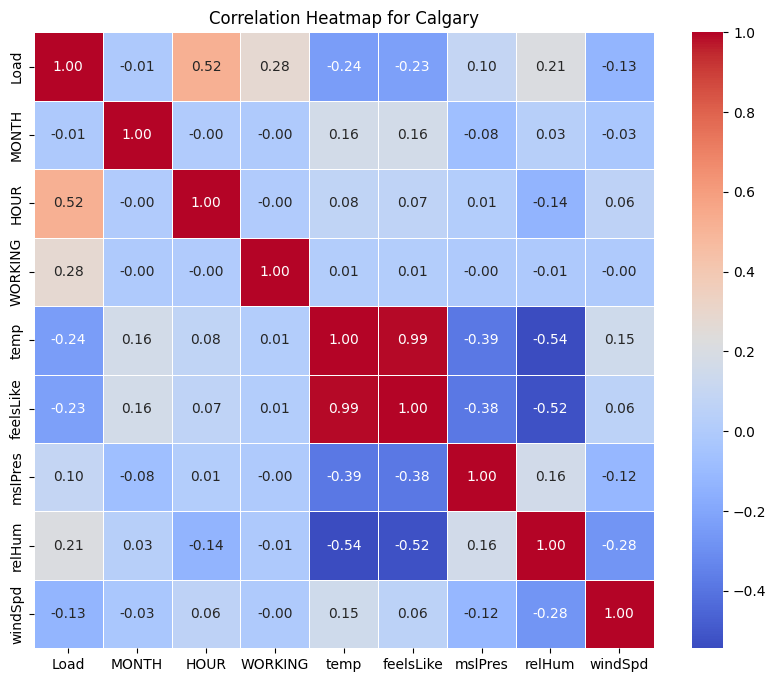

In [ ]:
# Calculate the correlation matrix
correlation_matrix = calgary.corr()

# Plot the correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Calgary')
plt.show()

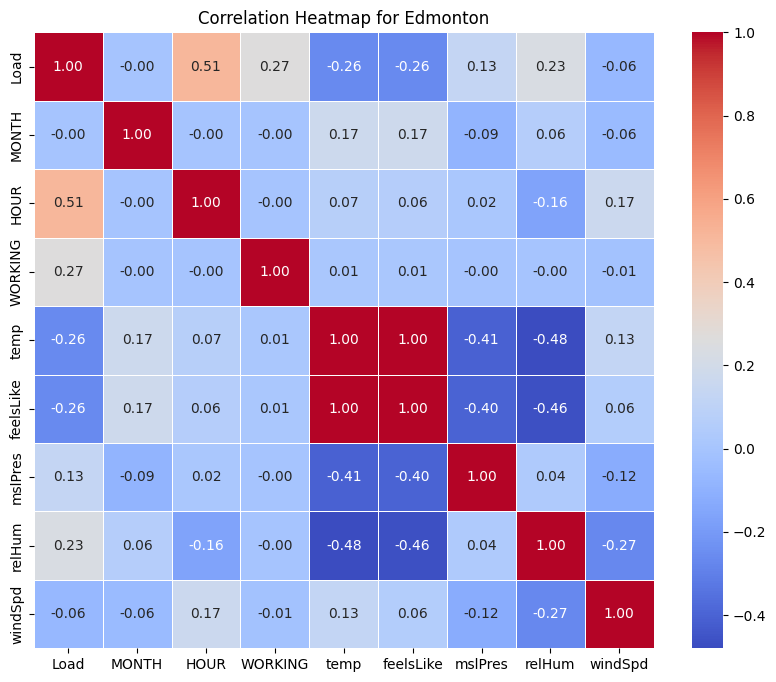

In [ ]:
# Create dataframe for Edmonton
edmonton = create_city_load_and_weather(alberta_load, 'Edmonton', selected_columns)

# Calculate the correlation matrix
correlation_matrix = edmonton.corr()

# Plot the correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Edmonton')
plt.show()

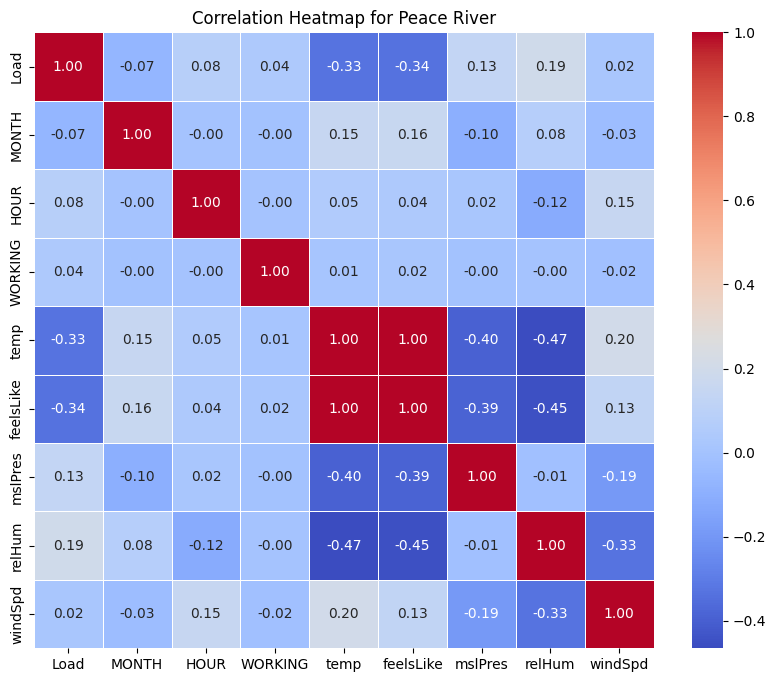

In [ ]:
# Create dataframe for Peace River
peaceriver = create_city_load_and_weather(alberta_load, 'Peace River', selected_columns)

# Calculate the correlation matrix
correlation_matrix = peaceriver.corr()

# Plot the correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap for Peace River')
plt.show()

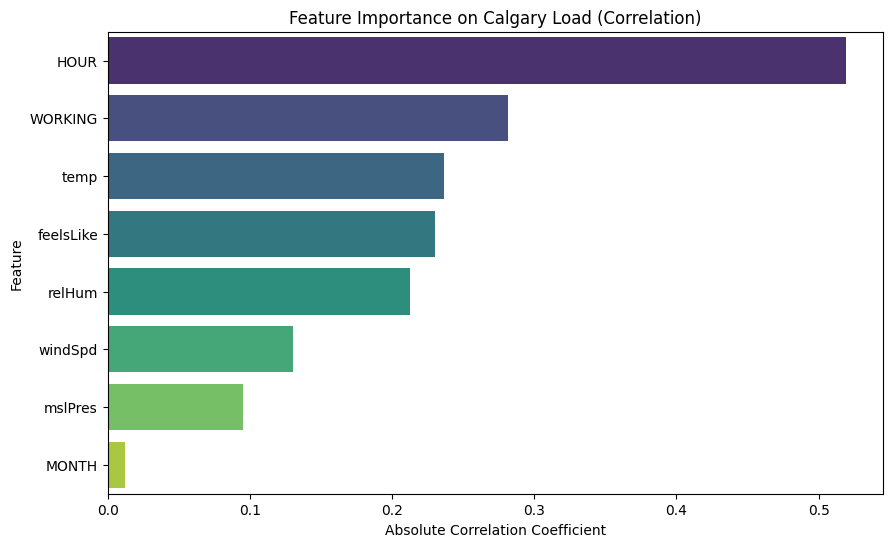

In [ ]:
# Calculate the correlation matrix
corr_matrix = calgary.corr()

# Extract the correlation of each feature with 'Load', excluding 'Load' itself
correlation_with_load = corr_matrix['Load'].abs().sort_values(ascending=False).drop('Load')

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_load.values, y=correlation_with_load.index, palette='viridis')
plt.xlabel('Absolute Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance on Calgary Load (Correlation)')
plt.show()

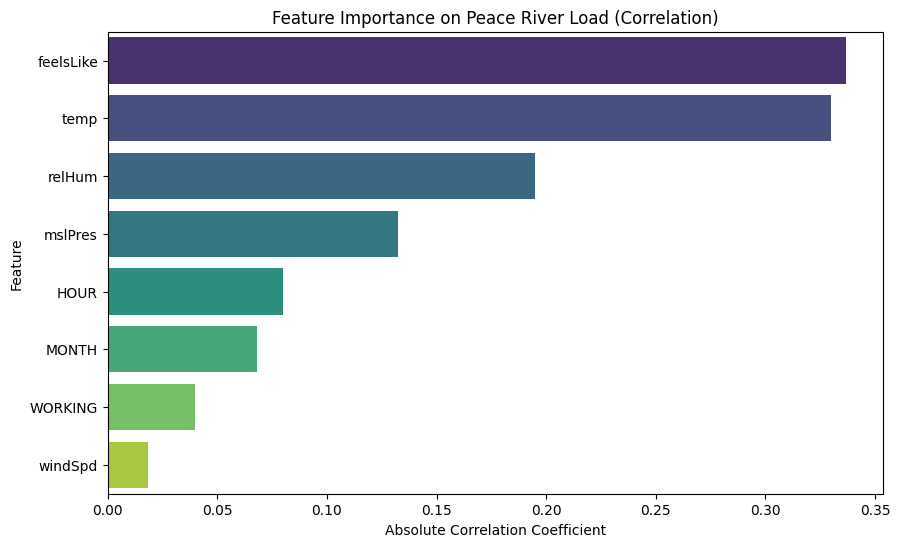

In [ ]:
# Calculate the correlation matrix
corr_matrix = peaceriver.corr()

# Extract the correlation of each feature with 'Load'
correlation_with_load = corr_matrix['Load'].abs().sort_values(ascending=False).drop('Load')

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_load.values, y=correlation_with_load.index, palette='viridis')
plt.xlabel('Absolute Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance on Peace River Load (Correlation)')
plt.show()

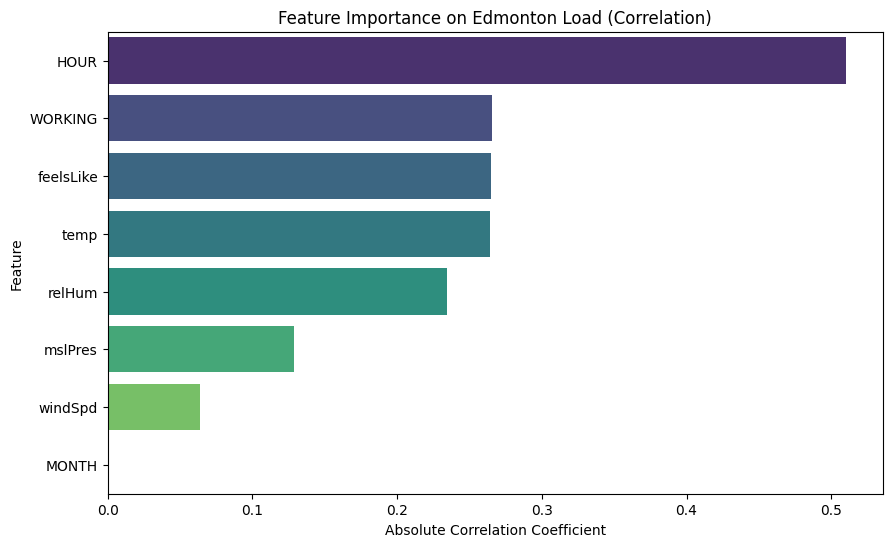

In [ ]:
# Calculate the correlation matrix
corr_matrix = edmonton.corr()

# Extract the correlation of each feature with 'Load', excluding 'Load' itself
correlation_with_load = corr_matrix['Load'].abs().sort_values(ascending=False).drop('Load')

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_load.values, y=correlation_with_load.index, palette='viridis')
plt.xlabel('Absolute Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance on Edmonton Load (Correlation)')
plt.show()

The plots above show an obvious similarity between Calgary and Edmonton, while a totally different correlation between input and output features for the city of Peace River. This will be used as a justification evidence for the transfer learning section.
To further collect evidence for what we could expect to see, here is another visualization plot to show the similarity/dissimilarity among these three selected cities:

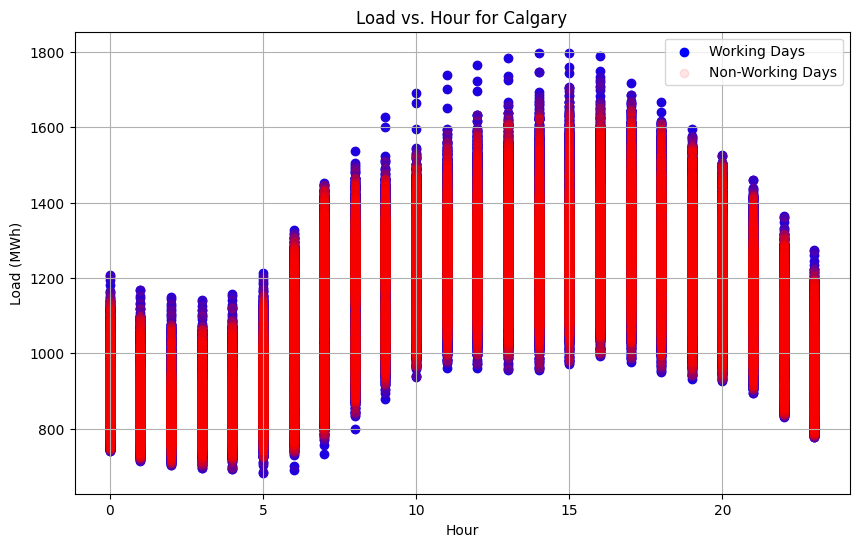

In [ ]:
# Plot load vs. HOUR for both working and non-working days
plt.figure(figsize=(10, 6))

# Plot working days data (blue color)
plt.scatter(calgary['HOUR'], calgary['Load'], color='blue', label='Working Days')

# Plot non-working days data with slight transparency (red color)
plt.scatter(calgary['HOUR'], calgary['Load'], color='red', alpha=0.1, label='Non-Working Days')

plt.xlabel('Hour')
plt.ylabel('Load (MWh)')
plt.title('Load vs. Hour for Calgary')
plt.legend()
plt.grid(True)
plt.show()

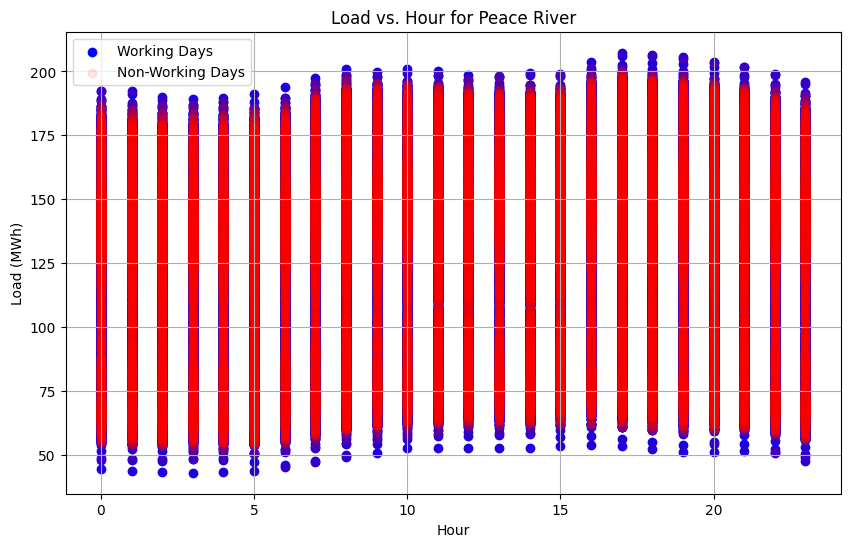

In [ ]:
# Plot load vs. HOUR for both working and non-working days
plt.figure(figsize=(10, 6))

# Plot working days data (blue color)
plt.scatter(peaceriver['HOUR'], peaceriver['Load'], color='blue', label='Working Days')

# Plot non-working days data with slight transparency (red color)
plt.scatter(peaceriver['HOUR'], peaceriver['Load'], color='red', alpha=0.1, label='Non-Working Days')

plt.xlabel('Hour')
plt.ylabel('Load (MWh)')
plt.title('Load vs. Hour for Peace River')
plt.legend()
plt.grid(True)
plt.show()

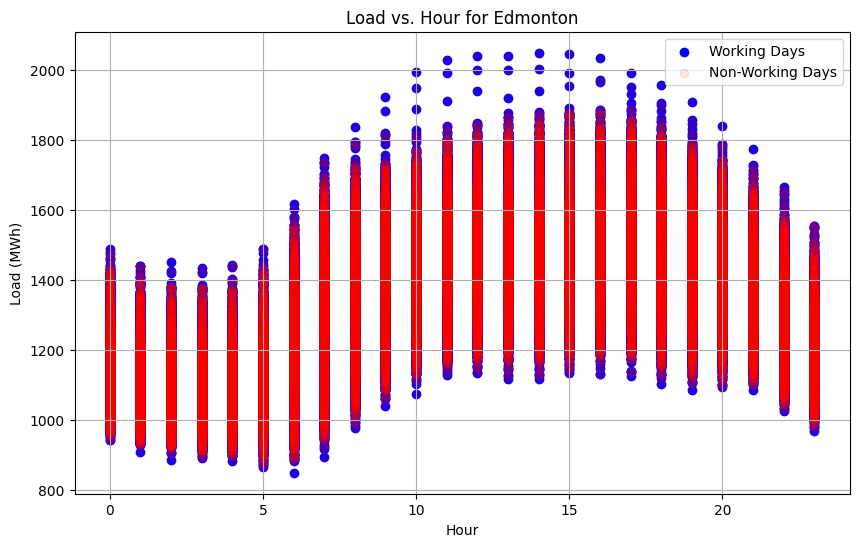

In [ ]:
# Plot load vs. HOUR for both working and non-working days
plt.figure(figsize=(10, 6))

# Plot working days data (blue color)
plt.scatter(edmonton['HOUR'], edmonton['Load'], color='blue', label='Working Days')

# Plot non-working days data with slight transparency (red color)
plt.scatter(edmonton['HOUR'], edmonton['Load'], color='red', alpha=0.1, label='Non-Working Days')

plt.xlabel('Hour')
plt.ylabel('Load (MWh)')
plt.title('Load vs. Hour for Edmonton')
plt.legend()
plt.grid(True)
plt.show()

Of all first chosen parameters, after some basic feature engineering analysis, the following can be selected for modelling which have the biggest impact on the load column (base on our base model, Calgary):

*   Hour of the day
*   Working/non-working day
*   Temperature
*   Relative humidity

Note: feelsLike strongly correlates with temperature, so it is not used in presence of temperature.

In [ ]:
selected_columns = ['DATE', 'HOUR', 'WORKING', 'Load', 'temp', 'relHum']
calgary = create_city_load_and_weather(alberta_load, 'Calgary', selected_columns)
peaceriver = create_city_load_and_weather(alberta_load, 'Peace River', selected_columns)
edmonton = create_city_load_and_weather(alberta_load, 'Edmonton', selected_columns)

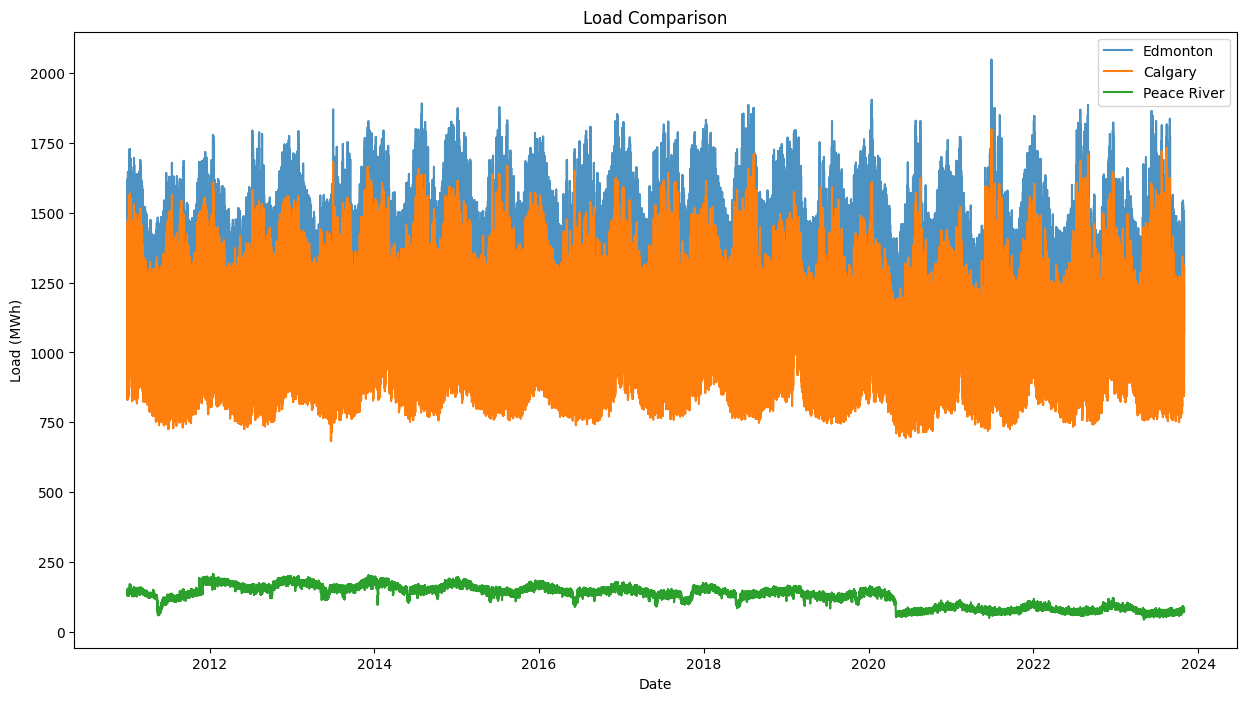

In [ ]:
# Plot all three datasets on the same plot
plt.figure(figsize=(15, 8))
plt.plot(edmonton['DATE'], edmonton['Load'], alpha=0.8, label='Edmonton')
plt.plot(calgary['DATE'], calgary['Load'], label='Calgary')
plt.plot(peaceriver['DATE'], peaceriver['Load'], label='Peace River')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Load (MWh)')
plt.title('Load Comparison')
plt.legend()

The plot above shows that both minimum and maximum load values of Edmonton are higher than Calgary's, but their pattern over years are similar. The impact of this will be shown in the modelling section.
On the other hand, Peace River has not only a significantly lower load values, but also a completely different pattern over time. We will see the effect of this too.

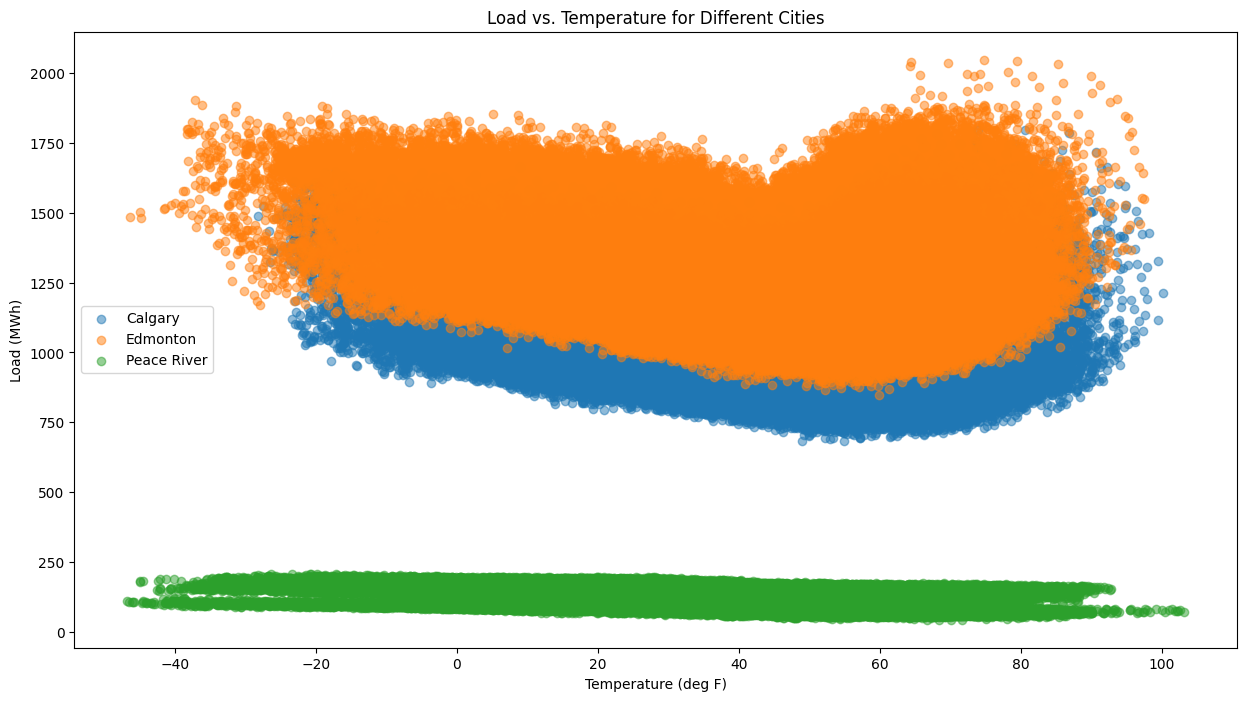

In [ ]:
# Plot load vs. temperature for each city on the same plot
plt.figure(figsize=(15, 8))

# Plot load vs. temp for Calgary
plt.scatter(calgary['temp'], calgary['Load'], label='Calgary', alpha=0.5)

# Plot load vs. temp for Edmonton
plt.scatter(edmonton['temp'], edmonton['Load'], label='Edmonton', alpha=0.5)

# Plot load vs. temp for Peace River
plt.scatter(peaceriver['temp'], peaceriver['Load'], label='Peace River', alpha=0.5)

# Add labels and legend
plt.xlabel('Temperature (deg F)')
plt.ylabel('Load (MWh)')
plt.title('Load vs. Temperature for Different Cities')
plt.legend()

This is also another helpful plot to investigate the response of load to temperature, as an important feature that correlates strongly with load.

These are all helpful information to justify different models' similarity and dissimilarity

**Data Preparation**

Looking for missing values:

In [ ]:
# Iterate over each column
for column in calgary.columns:
    # Count the number of rows with null or zero values for the current column
    num_rows_with_null = (calgary[column].isnull()).sum()

    # Print the column name and the number of rows with null or zero values
    print(f"Column '{column}': {num_rows_with_null} rows with null values")

Column 'DATE': 0 rows with null values
Column 'HOUR': 0 rows with null values
Column 'WORKING': 0 rows with null values
Column 'Load': 0 rows with null values
Column 'temp': 0 rows with null values
Column 'relHum': 0 rows with null values


In [ ]:
# Iterate over each column
for column in peaceriver.columns:
    # Count the number of rows with null or zero values for the current column
    num_rows_with_null = (peaceriver[column].isnull()).sum()

    # Print the column name and the number of rows with null or zero values
    print(f"Column '{column}': {num_rows_with_null} rows with null values")

Column 'DATE': 0 rows with null values
Column 'HOUR': 0 rows with null values
Column 'WORKING': 0 rows with null values
Column 'Load': 0 rows with null values
Column 'temp': 0 rows with null values
Column 'relHum': 0 rows with null values


In [ ]:
# Iterate over each column
for column in edmonton.columns:
    # Count the number of rows with null or zero values for the current column
    num_rows_with_null = (edmonton[column].isnull()).sum()

    # Print the column name and the number of rows with null or zero values
    print(f"Column '{column}': {num_rows_with_null} rows with null values")

Column 'DATE': 0 rows with null values
Column 'HOUR': 0 rows with null values
Column 'WORKING': 0 rows with null values
Column 'Load': 0 rows with null values
Column 'temp': 0 rows with null values
Column 'relHum': 0 rows with null values


In [ ]:
# Find rows where DEMAND is zero
rows_with_zero_demand = calgary[calgary['Load'] == 0]

# Print the rows with zero DEMAND
print("Rows with DEMAND = 0:")
print(rows_with_zero_demand)

Rows with DEMAND = 0:
Empty DataFrame
Columns: [DATE, HOUR, WORKING, Load, temp, relHum]
Index: []


In [ ]:
# Find rows where DEMAND is zero
rows_with_zero_demand = peaceriver[peaceriver['Load'] == 0]

# Print the rows with zero DEMAND
print("Rows with DEMAND = 0:")
print(rows_with_zero_demand)

Rows with DEMAND = 0:
Empty DataFrame
Columns: [DATE, HOUR, WORKING, Load, temp, relHum]
Index: []


In [ ]:
# Find rows where DEMAND is zero
rows_with_zero_demand = edmonton[edmonton['Load'] == 0]

# Print the rows with zero DEMAND
print("Rows with DEMAND = 0:")
print(rows_with_zero_demand)

Rows with DEMAND = 0:
Empty DataFrame
Columns: [DATE, HOUR, WORKING, Load, temp, relHum]
Index: []


Splitting for training:
We first chose 2011 to 2018 for training, 2019 and 2020 for validation, and 2021 to 2023 for testing. However, we observed (as shown below for one of our best matched models) that the model was not able to predict the higher end values of load with similar accuracy of the rest of the test dataset. As shown below, for a chunk of load column, the actual (normalized) values went above 1, while the predicted load for this piece of data never went beyond unity. This showed higher consumption (load values) by the city of Calgary in the recent years (2021-2023) that had been chosen for the test dataset (data normalization is based on the train dataset). The reason could be higher poulation and growth rate of the city in the resent years.
As a result, we decided to reverse the direction of our data split and chose:

*   Train: 2016 -2023
*   Validation: 2014 - 2015
*   Test: 2011 - 2013




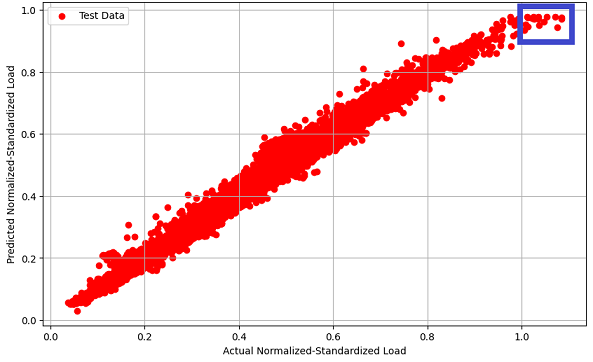
```
Underprediction of higher end values with the initial data split
```



In [ ]:

# Split the data into training, validation, and testing sets
training_data = calgary[(calgary['DATE'].dt.year >= 2016)]
validation_data = calgary[(calgary['DATE'].dt.year.isin([2014, 2015]))]
testing_data = calgary[(calgary['DATE'].dt.year.isin([2011, 2012, 2013]))]

# Print the shapes of the data subsets
print("Training data shape:", training_data.shape)
print("Validation data shape:", validation_data.shape)
print("Testing data shape:", testing_data.shape)

Training data shape: (68659, 6)
Validation data shape: (17518, 6)
Testing data shape: (26301, 6)


In [ ]:
# Separate features (X) and target variable (y) for training, validation, and testing sets
X_train = training_data.drop(columns=['Load'])
y_train = training_data['Load']
X_validation = validation_data.drop(columns=['Load'])
y_validation = validation_data['Load']
X_test = testing_data.drop(columns=['Load'])
y_test = testing_data['Load']

X_peaceriver = peaceriver.drop(columns=['Load'])
y_peaceriver = peaceriver['Load']

X_edmonton = edmonton.drop(columns=['Load'])
y_edmonton = edmonton['Load']

In [ ]:
# Drop the Date column as we don't need it during ML process
X_train = X_train.drop(columns=['DATE'])
X_validation = X_validation.drop(columns=['DATE'])
X_test = X_test.drop(columns=['DATE'])

X_peaceriver = X_peaceriver.drop(columns=['DATE'])
X_edmonton = X_edmonton.drop(columns=['DATE'])

In [ ]:
# Check for missing data in X_train
missing_data_X_train = X_train.isnull().sum()
print("Missing data in X_train:")
print(missing_data_X_train)

# Check for missing data in y_train
missing_data_y_train = y_train.isnull().sum()
print("\nMissing data in y_train:")
print(missing_data_y_train)

# Check for missing data in X_validation
missing_data_X_validation = X_validation.isnull().sum()
print("\nMissing data in X_validation:")
print(missing_data_X_validation)

# Check for missing data in y_validation
missing_data_y_validation = y_validation.isnull().sum()
print("\nMissing data in y_validation:")
print(missing_data_y_validation)

# Check for missing data in X_test
missing_data_X_test = X_test.isnull().sum()
print("\nMissing data in X_test:")
print(missing_data_X_test)

# Check for missing data in y_test
missing_data_y_test = y_test.isnull().sum()
print("\nMissing data in y_test:")
print(missing_data_y_test)

Missing data in X_train:
HOUR       0
WORKING    0
temp       0
relHum     0
dtype: int64

Missing data in y_train:
0

Missing data in X_validation:
HOUR       0
WORKING    0
temp       0
relHum     0
dtype: int64

Missing data in y_validation:
0

Missing data in X_test:
HOUR       0
WORKING    0
temp       0
relHum     0
dtype: int64

Missing data in y_test:
0


In [ ]:
# Convert y_train to DataFrame with column name 'DEMAND'
y_train = y_train.to_frame(name='Load')

# Convert y_validation to DataFrame with column name 'DEMAND'
y_validation = y_validation.to_frame(name='Load')

# Convert y_test to DataFrame with column name 'DEMAND'
y_test = y_test.to_frame(name='Load')

y_peaceriver = y_peaceriver.to_frame(name='Load')
y_edmonton = y_edmonton.to_frame(name='Load')

In [ ]:
# Extract input and output names
input_cols = X_train.columns
output_col = y_train.columns

print(output_col)

Index(['Load'], dtype='object')


In [ ]:
# Standardize the input features
std_scaler_input = StandardScaler()

# Fit and transform input features for training set (Standardization)
train_data_standardized_input = std_scaler_input.fit_transform(X_train[input_cols])

# Transform input features for testing and validation sets (Standardization)
test_data_standardized_input = std_scaler_input.transform(X_test[input_cols])
validation_data_standardized_input = std_scaler_input.transform(X_validation[input_cols])

peaceriver_standardized_input = std_scaler_input.transform(X_peaceriver[input_cols])
edmonton_standardized_input = std_scaler_input.transform(X_edmonton[input_cols])

# Normalize the standardized input features
norm_scaler_input = MinMaxScaler()

# Fit and transform input features for training set (Normalization)
train_data_normalized_input = norm_scaler_input.fit_transform(train_data_standardized_input)

# Transform input features for testing and validation sets (Normalization)
test_data_normalized_input = norm_scaler_input.transform(test_data_standardized_input)
validation_data_normalized_input = norm_scaler_input.transform(validation_data_standardized_input)

peaceriver_normalized_input = norm_scaler_input.transform(peaceriver_standardized_input)
edmonton_normalized_input = norm_scaler_input.transform(edmonton_standardized_input)

In [ ]:
# Standardize the output vector
std_scaler_output = StandardScaler()

# Fit and transform output feature for training set (Standardization)
train_data_standardized_output = std_scaler_output.fit_transform(y_train[output_col])

# Transform output feature for testing and validation sets (Standardization)
test_data_standardized_output = std_scaler_output.transform(y_test[output_col])
validation_data_standardized_output = std_scaler_output.transform(y_validation[output_col])

peaceriver_standardized_output = std_scaler_output.transform(y_peaceriver[output_col])
edmonton_standardized_output = std_scaler_output.transform(y_edmonton[output_col])

# Normalize the standardized output vector
norm_scaler_output = MinMaxScaler()

# Fit and transform output feature for training set (Normalization)
train_data_normalized_output = norm_scaler_output.fit_transform(train_data_standardized_output)

# Transform output feature for testing and validation sets (Normalization)
test_data_normalized_output = norm_scaler_output.transform(test_data_standardized_output)
validation_data_normalized_output = norm_scaler_output.transform(validation_data_standardized_output)

peaceriver_normalized_output = norm_scaler_output.transform(peaceriver_standardized_output)
edmonton_normalized_output = norm_scaler_output.transform(edmonton_standardized_output)

**Modelling**

Generally speaking, we have tried two types of modelling, with and without considering the time series nature of ourdataset.
Starting from a regular training, without considering the impact of load history (disregarding its time series nature), we practiced several methods like Random Forest Regressor, Neural Networks, Gradient Boosting, etc. Almost all of them offered similar accuracies. Of those, we present GBM here.

**1. Gradient Boosting Model (GBM)**

In [ ]:
# Initialize and train the GBM model
gbm_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gbm_model.fit(train_data_normalized_input, train_data_normalized_output.ravel())

GradientBoostingRegressor(max_depth=5, random_state=42)

In [ ]:
# Predict on validation set
validation_predictions = gbm_model.predict(validation_data_normalized_input)

# Calculate validation RMSE
validation_rmse = np.sqrt(mean_squared_error(validation_data_normalized_output, validation_predictions))
# Calculate R-squared for validation set
validation_r2 = r2_score(validation_data_normalized_output, validation_predictions)

# Predict on test set
test_predictions = gbm_model.predict(test_data_normalized_input)

# Calculate test RMSE
test_rmse = np.sqrt(mean_squared_error(test_data_normalized_output, test_predictions))
# Calculate R-squared for test set
test_r2 = r2_score(test_data_normalized_output, test_predictions)

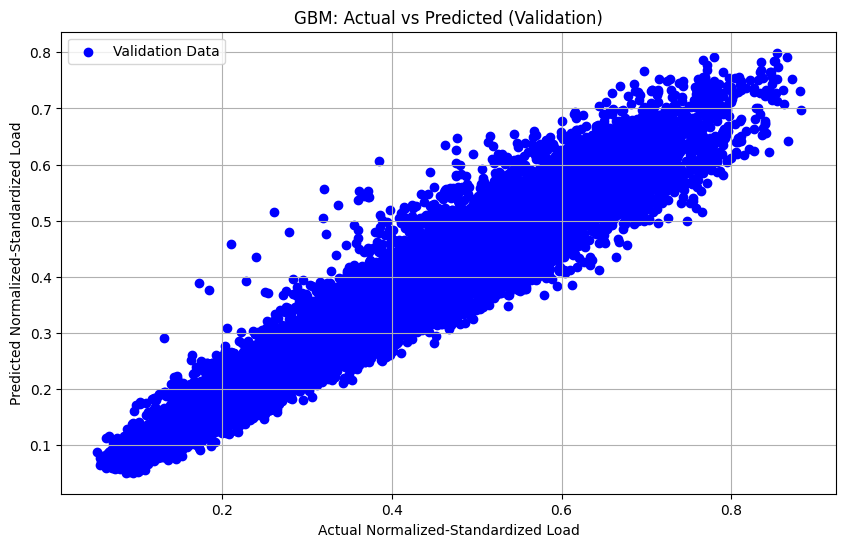

Validation RMSE: 0.06143520478552048
Validation R-squared: 0.8891417959616918


In [ ]:
# Plot actual vs predicted values for validation set
plt.figure(figsize=(10, 6))
plt.scatter(validation_data_normalized_output, validation_predictions, color='blue', label='Validation Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('GBM: Actual vs Predicted (Validation)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for validation set
print("Validation RMSE:", validation_rmse)
print("Validation R-squared:", validation_r2)

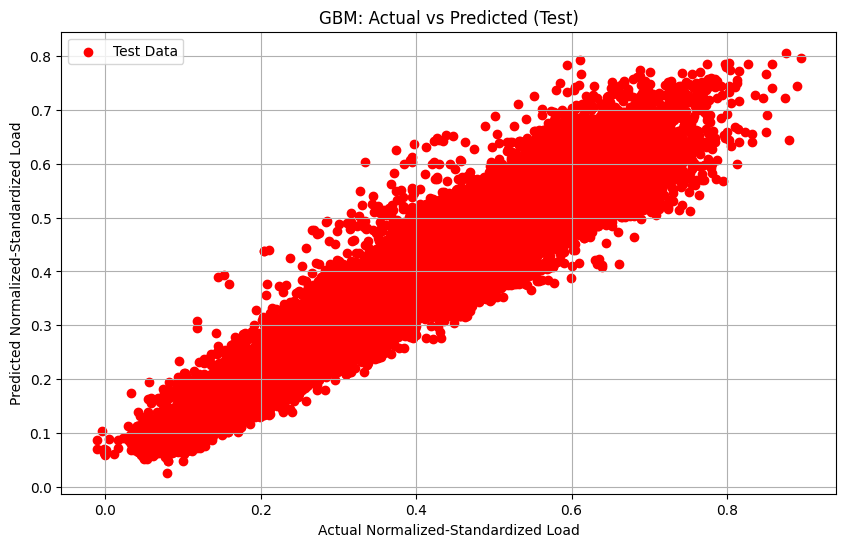

Test RMSE: 0.051824942695743025
Test R-squared: 0.9189296901835995


In [ ]:
# Plot actual vs predicted values for test set
plt.figure(figsize=(10, 6))
plt.scatter(test_data_normalized_output, test_predictions, color='red', label='Test Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('GBM: Actual vs Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()


# Print RMSE and R-squared for test set
print("Test RMSE:", test_rmse)
print("Test R-squared:", test_r2)

As presented above, when each row of data is interpreted individually without considering the dependency to their history (time series), the average accuracy would not be great. Note that the prediction is just for one time step ahead, and an average accuracy of 82% would not be impressive when the target is prediction of some days ahead. (The single point prediction is used in a loop to be considered as the input for the next cycle. For a target of 3 days prediction, for instance, the uncertainty is accumulated in 72 cycles. Thus, we need a much higher average accuracy for "single point prediction" to be able to deliver a quality product.)

Now that we learned we cannot ignore the dependency nature of our data, let's present the models that include the time series properties. But before we dive into it, we first need to address some fundamental and basic questions; e.g. how deep we should let the model to look back and learn from its history, how we should implement this history, do other parameters have a lag to impact the output value, ...

ACF feature analysis to find the proper timestep history: Autocorrelation Function (ACF) is a helpful tool for understanding the correlation between a time series and its lagged values. The ACF provides insights into the temporal dependencies within the time series data.

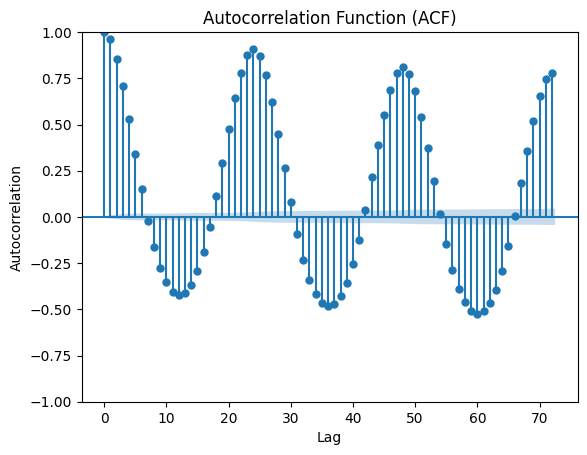

In [ ]:
# 'Calgary Load' is the target variable
target_variable = y_train['Load']

# Calculate ACF and PACF
acf = sm.tsa.acf(target_variable, fft=False)

# Plot ACF
plot_acf(target_variable, lags=72)  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

As can be seen, each time step (originated at point zero), has the strongest dependency to its first preceding step, as expected, which then decreases and becomes almost no dependencies to the 7th preceding time step. The correlation keeps dropping until it reaches the most negative value at the 12th lag (most powerful reverse correlation which is also considered an important point for the modelling stage - similar to correlation matrix). The dependency again grows to the highest peak (except the first preceding time step) at the 24th preceding hour.
We can now utilize these important historical points with different approaches; e.g. using only the peak points, using the full history points up to the trough (12 hours in this case), using full history of the last 24 hours. We will compare the result of each approach.   

**2. Random Forest with Time Series Features**

In [ ]:
# Prepare lagged features for the time series data
def create_lagged_features(data, lag):
    lagged_features = [data.shift(i) for i in range(1, lag)]
    return pd.concat([data] + lagged_features, axis=1)

In [ ]:
# Columns to build the timeseries dataframes
input_cols = input_cols.tolist()

This is the function to create a time series dataframe with the desired lag. The result will be a dataframe including the input and output features plus the preceding load data (as additional input features) for lag-value time steps back.

In [ ]:
# Function to fill in the timeseries dataframes
def fill_timeseries_df(input, output, lag):
    # Shifted dataframe
    lagged_load = create_lagged_features(pd.DataFrame(output)[0], lag)
    lagged_load = lagged_load.transpose().iloc[::-1].iloc[:, lag-1:]

    # Create an empty DataFrames
    timeseries_df = pd.DataFrame(columns=['load ' + str(i) + 'hr bk' for i in range(lag, 0, -1)] + input_cols)

    # Number of iterations
    num_iterations = int((output.shape[0] - lag) / lag)

    # Define an empty list to store column-wise DataFrames
    dfs = []

    # Fill timeseries_train column-wise
    for iteration in range(num_iterations):
        df_list = []
        for i in range(iteration * lag + 1, (iteration + 1) * lag + 1):
            # Create a dictionary to store column data
            column_data = {
                input_cols[0] : input[i-1+lag][0],
                input_cols[1] : input[i-1+lag][1],
                input_cols[2] : input[i-1+lag][2],
                input_cols[3] : input[i-1+lag][3],
                'Load': output[i-1+lag][0]
            }

            # Fill load columns from lagged_load
            for j in range(lag):
                column_data['load ' + str(j + 1) + 'hr bk'] = lagged_load.iloc[lag - j - 1, i - 1]

            # Append the column data to the list
            df_list.append(pd.DataFrame([column_data]))

        # Concatenate the DataFrames in the list
        df_concat = pd.concat(df_list, ignore_index=True)

        # Append the concatenated DataFrame to the list
        dfs.append(df_concat)

    # Concatenate all DataFrames in the list along axis 1 (columns)
    timeseries_df = pd.concat(dfs, axis=0, ignore_index=True)

    return timeseries_df

In [ ]:
lag = 24
timeseries_train = fill_timeseries_df(train_data_normalized_input, train_data_normalized_output, lag)
timeseries_valid = fill_timeseries_df(validation_data_normalized_input, validation_data_normalized_output, lag)
timeseries_test = fill_timeseries_df(test_data_normalized_input, test_data_normalized_output, lag)

In [ ]:
timeseries_train

,HOUR,WORKING,temp,relHum,Load,load 1hr bk,load 2hr bk,load 3hr bk,load 4hr bk,load 5hr bk,...,load 15hr bk,load 16hr bk,load 17hr bk,load 18hr bk,load 19hr bk,load 20hr bk,load 21hr bk,load 22hr bk,load 23hr bk,load 24hr bk
0,0.000000,0.0,0.450834,0.420064,0.224715,0.283008,0.355028,0.419563,0.460472,0.493877,...,0.286061,0.269147,0.251656,0.223830,0.195550,0.174542,0.176811,0.197061,0.229580,0.266313
1,0.043478,0.0,0.426445,0.465114,0.184080,0.224715,0.283008,0.355028,0.419563,0.460472,...,0.324549,0.286061,0.269147,0.251656,0.223830,0.195550,0.174542,0.176811,0.197061,0.229580
2,0.086957,0.0,0.425588,0.441270,0.161041,0.184080,0.224715,0.283008,0.355028,0.419563,...,0.351595,0.324549,0.286061,0.269147,0.251656,0.223830,0.195550,0.174542,0.176811,0.197061
3,0.130435,0.0,0.399797,0.495440,0.153116,0.161041,0.184080,0.224715,0.283008,0.355028,...,0.363857,0.351595,0.324549,0.286061,0.269147,0.251656,0.223830,0.195550,0.174542,0.176811
4,0.173913,0.0,0.401590,0.475332,0.158358,0.153116,0.161041,0.184080,0.224715,0.283008,...,0.361280,0.363857,0.351595,0.324549,0.286061,0.269147,0.251656,0.223830,0.195550,0.174542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68611,0.000000,1.0,0.490494,0.615317,0.164864,0.196453,0.252812,0.333954,0.424688,0.491397,...,0.497345,0.499049,0.504982,0.477268,0.354338,0.221330,0.156807,0.135458,0.136163,0.154802
68612,0.043478,1.0,0.477014,0.672014,0.147835,0.164864,0.196453,0.252812,0.333954,0.424688,...,0.484058,0.497345,0.499049,0.504982,0.477268,0.354338,0.221330,0.156807,0.135458,0.136163
68613,0.086957,1.0,0.470313,0.703329,0.145337,0.147835,0.164864,0.196453,0.252812,0.333954,...,0.485006,0.484058,0.497345,0.499049,0.504982,0.477268,0.354338,0.221330,0.156807,0.135458
68614,0.130435,1.0,0.455976,0.724096,0.163358,0.145337,0.147835,0.164864,0.196453,0.252812,...,0.475387,0.485006,0.484058,0.497345,0.499049,0.504982,0.477268,0.354338,0.221330,0.156807


In [ ]:
# Separate input and output features
X = timeseries_train.drop(columns=['Load'])  # Input features (all columns except 'Load', the output feature)
y = timeseries_train['Load']  # Output feature

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

We can save the model for further use which would save time to utilize it without the need to re-run all the steps. The model can be recalled by load method:

```
# Save the trained model to a file
dump(rf_model, aeso_data_dir + '/models/rf_model_calgary.joblib')

# Later, to load the model back into memory
rf_model = load(aeso_data_dir + '/models/rf_model_calgary.joblib')
```



In [ ]:
# Predict on validation set
validation_predictions_rf = rf_model.predict(timeseries_valid.drop(columns=['Load']))

# Calculate R^2
validation_r2_rf = r2_score(timeseries_valid['Load'], validation_predictions_rf)

# Calculate RMSE
validation_rmse_rf = np.sqrt(mean_squared_error(timeseries_valid['Load'], validation_predictions_rf))

print("Random Forest with Time Series Features (Ensembling):")
print("Validation RMSE:", validation_rmse_rf)
print("Validation R-squared:", validation_r2_rf)

Random Forest with Time Series Features (Ensembling):
Validation RMSE: 0.013182648354753872
Validation R-squared: 0.9949019946313502


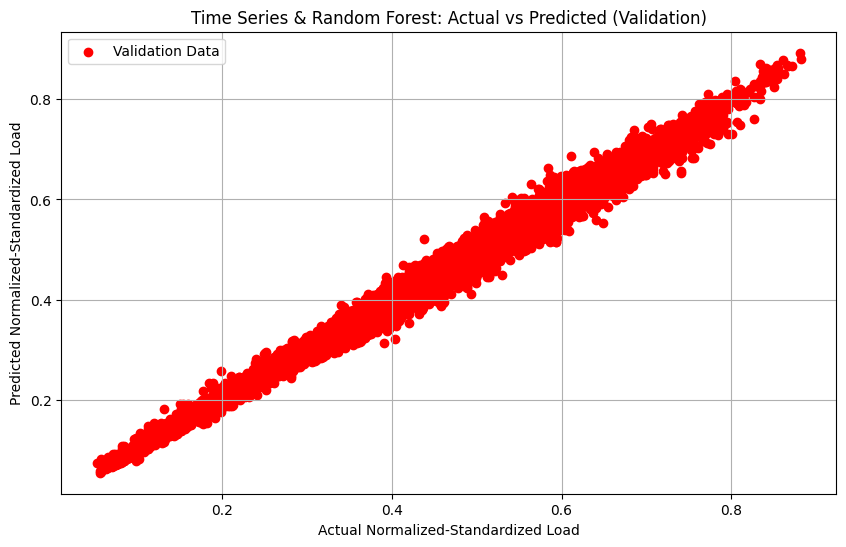

Validation RMSE: 0.013182648354753872
Validation R-squared: 0.9949019946313502


In [ ]:
# Plot actual vs predicted values for validation set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_valid['Load'], validation_predictions_rf, color='red', label='Validation Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('Time Series & Random Forest: Actual vs Predicted (Validation)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for validation set
print("Validation RMSE:", validation_rmse_rf)
print("Validation R-squared:", validation_r2_rf)

In [ ]:
# Predict on test set
test_predictions_rf = rf_model.predict(timeseries_test.drop(columns=['Load']))

# Calculate R^2
test_r2_rf = r2_score(timeseries_test['Load'], test_predictions_rf)

# Calculate RMSE
test_rmse_rf = np.sqrt(mean_squared_error(timeseries_test['Load'], test_predictions_rf))

print("Random Forest with Time Series Features (Ensembling):")
print("Test RMSE:", test_rmse_rf)
print("Test R-squared:", test_r2_rf)

Random Forest with Time Series Features (Ensembling):
Test RMSE: 0.012988284754117865
Test R-squared: 0.9949116996565771


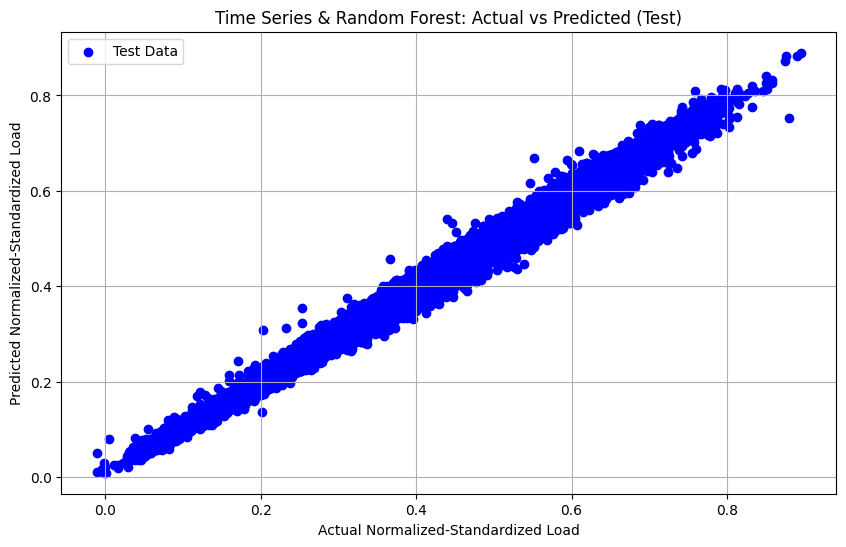

Test RMSE: 0.012988284754117865
Test R-squared: 0.9949116996565771


In [ ]:
# Plot actual vs predicted values for test set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_test['Load'], test_predictions_rf, color='blue', label='Test Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('Time Series & Random Forest: Actual vs Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for test set
print("Test RMSE:", test_rmse_rf)
print("Test R-squared:", test_r2_rf)

Predicting hours ahead in a loop:
Now that we have a trained model with quite high average accuracy (validated and tested), we can try predicting the load for an upcoming period of time. In this study we target three days (72 hours) prediction.

In [ ]:
def multiple_prediction(timeseries, pred_hr, model):
    # Choose a random starting index
    random_start_index = np.random.randint(low=0, high=len(timeseries) - pred_hr + 1)  # To ensure enough rows remain

    # Select the next 72 rows following the random starting index
    random_rows = timeseries.iloc[random_start_index:random_start_index + pred_hr]

    # Save the actual load before it changes
    actual_load = random_rows['Load'].copy()

    for hr in range(pred_hr):
        pred = model.predict(pd.DataFrame(random_rows.iloc[hr]).transpose().drop(columns=['Load']))
        random_rows['Load'][random_start_index + hr] = pred
        hr_bk = random_start_index + hr
        for future_hr in range(1, lag+1):
            hr_bk = hr_bk + 1
            if hr_bk < random_start_index + pred_hr:
                random_rows[f'load {str(future_hr)}hr bk'][hr_bk] = pred

    return (actual_load, random_rows, random_start_index)

In [ ]:
pred_hr = 72
actual_load, prediction, random_start_index = multiple_prediction(timeseries_test, pred_hr, rf_model)

In [ ]:
prediction # Normalized values

,HOUR,WORKING,temp,relHum,Load,load 1hr bk,load 2hr bk,load 3hr bk,load 4hr bk,load 5hr bk,...,load 15hr bk,load 16hr bk,load 17hr bk,load 18hr bk,load 19hr bk,load 20hr bk,load 21hr bk,load 22hr bk,load 23hr bk,load 24hr bk
7174,1.000000,1.0,0.564984,0.176134,0.256702,0.353748,0.464643,0.534418,0.572781,0.553048,...,0.517847,0.492719,0.354037,0.196749,0.125681,0.111215,0.113041,0.130792,0.166613,0.237320
7175,0.000000,1.0,0.536621,0.198330,0.189875,0.256702,0.353748,0.464643,0.534418,0.572781,...,0.514727,0.517847,0.492719,0.354037,0.196749,0.125681,0.111215,0.113041,0.130792,0.166613
7176,0.043478,1.0,0.500857,0.286122,0.150609,0.189875,0.256702,0.353748,0.464643,0.534418,...,0.525161,0.514727,0.517847,0.492719,0.354037,0.196749,0.125681,0.111215,0.113041,0.130792
7177,0.086957,1.0,0.484962,0.308208,0.131108,0.150609,0.189875,0.256702,0.353748,0.464643,...,0.530356,0.525161,0.514727,0.517847,0.492719,0.354037,0.196749,0.125681,0.111215,0.113041
7178,0.130435,1.0,0.471872,0.351720,0.126307,0.131108,0.150609,0.189875,0.256702,0.353748,...,0.524257,0.530356,0.525161,0.514727,0.517847,0.492719,0.354037,0.196749,0.125681,0.111215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7241,0.782609,0.0,0.614072,0.340732,0.461333,0.434204,0.406875,0.387108,0.388399,0.394450,...,0.120315,0.130914,0.152323,0.189180,0.244383,0.319039,0.388391,0.429118,0.457286,0.480335
7242,0.826087,0.0,0.662771,0.297220,0.459484,0.461333,0.434204,0.406875,0.387108,0.388399,...,0.123795,0.120315,0.130914,0.152323,0.189180,0.244383,0.319039,0.388391,0.429118,0.457286
7243,0.869565,0.0,0.698613,0.231623,0.424416,0.459484,0.461333,0.434204,0.406875,0.387108,...,0.142988,0.123795,0.120315,0.130914,0.152323,0.189180,0.244383,0.319039,0.388391,0.429118
7244,0.913043,0.0,0.709522,0.219756,0.386338,0.424416,0.459484,0.461333,0.434204,0.406875,...,0.177873,0.142988,0.123795,0.120315,0.130914,0.152323,0.189180,0.244383,0.319039,0.388391


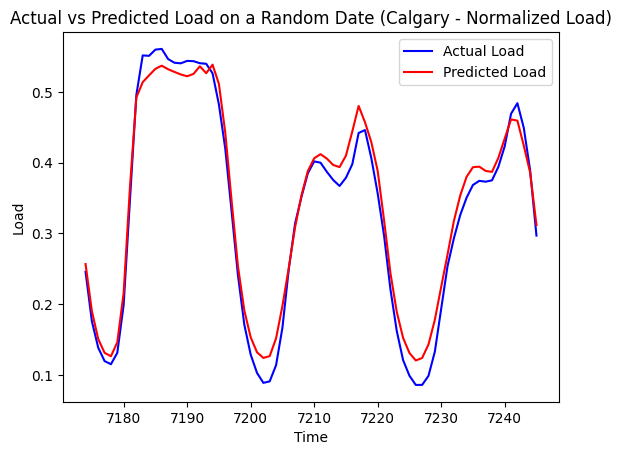

R-squared (r2): 0.9758318864344944
Root Mean Squared Error (RMSE): 0.023693336881630223


In [ ]:
# Plot actual vs. predicted loads for 72 hours ahead
plt.plot(actual_load, label='Actual Load', color='blue')
plt.plot(prediction['Load'], label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual vs Predicted Load on a Random Date (Calgary - Normalized Load)')
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2 = r2_score(actual_load, prediction['Load'])
rmse = np.sqrt(mean_squared_error(actual_load, prediction['Load']))

# Print r2 and rmse
print(f'R-squared (r2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

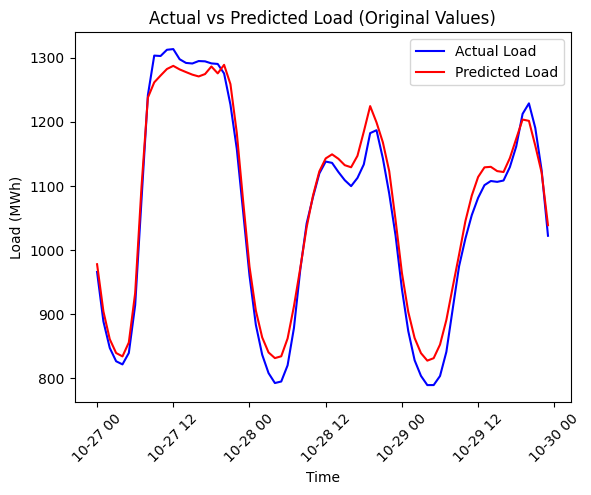

R-squared (r2): 0.9758318864344944
Root Mean Squared Error (RMSE): 0.023693336881630223 MWh


In [ ]:
# De-normalize de-standardize the actual and predicted loads
actual_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(actual_load.to_numpy().reshape(-1, 1)))
predicted_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(prediction['Load'].to_numpy().reshape(-1, 1)))

# Extract the first point of time (timestamp) from testing_data
first_point_of_time = testing_data['DATE'][random_start_index + 12]

# Extract the hour from testing_data at the first point of time
first_hour = testing_data['HOUR'][random_start_index + 12]

# Create the x-axis values starting from the first point of time and extending to pred_hr hours more
x_values = pd.date_range(start=first_point_of_time, periods=pred_hr, freq='H')

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2_denorm = r2_score(actual_load, prediction['Load'])
rmse_denorm = np.sqrt(mean_squared_error(actual_load, prediction['Load']))

# Plot actual vs. predicted loads for the hours ahead
plt.plot(x_values, actual_load_denorm, label='Actual Load', color='blue')
plt.plot(x_values, predicted_load_denorm, label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load (MWh)')
plt.title('Actual vs Predicted Load (Original Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Print r2 and rmse
print(f'R-squared (r2): {r2_denorm}')
print(f'Root Mean Squared Error (RMSE): {rmse_denorm} MWh')

**Modelling with only 3 history points (first preceding, trough - 12 hours back, and peak - 24 hours back)**

In [ ]:
selective_cols = input_cols.copy() + ['load 1hr bk', 'load 12hr bk', 'load ' + str(lag) + 'hr bk']

In [ ]:
# Separate input and output features
X = timeseries_train[selective_cols]
y = timeseries_train['Load']  # Output feature

# Train a Random Forest model
rf_model_selective_peaks = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_selective_peaks.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
# Predict on validation set
validation_predictions_rf = rf_model_selective_peaks.predict(timeseries_valid[selective_cols])

# Calculate R^2
validation_r2_rf = r2_score(timeseries_valid['Load'], validation_predictions_rf)

# Calculate RMSE
validation_rmse_rf = np.sqrt(mean_squared_error(timeseries_valid['Load'], validation_predictions_rf))

print("Random Forest with Selective Time Series Features (Ensembling):")
print("Validation RMSE:", validation_rmse_rf)
print("Validation R-squared:", validation_r2_rf)

Random Forest with Selective Time Series Features (Ensembling):
Validation RMSE: 0.015508050735323395
Validation R-squared: 0.9929447991842595


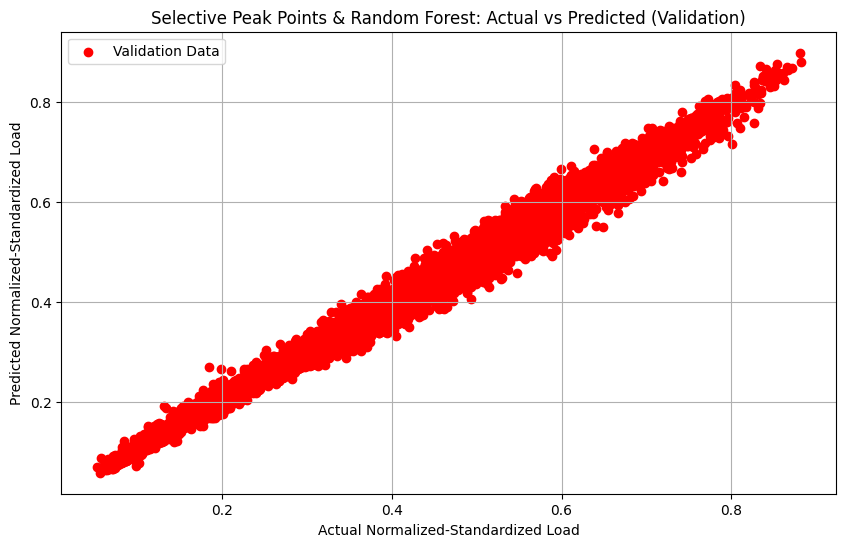

Validation RMSE: 0.015508050735323395
Validation R-squared: 0.9929447991842595


In [ ]:
# Plot actual vs predicted values for validation set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_valid['Load'], validation_predictions_rf, color='red', label='Validation Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('Selective Peak Points & Random Forest: Actual vs Predicted (Validation)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for validation set
print("Validation RMSE:", validation_rmse_rf)
print("Validation R-squared:", validation_r2_rf)

In [ ]:
selective_cols = input_cols.tolist().copy() + ['load 1hr bk', 'load 12hr bk', 'load ' + str(lag) + 'hr bk']
pred_hr = 72
selective_cols += ['Load']
# Choose a random starting index
random_start_index = np.random.randint(low=0, high=len(timeseries_test[selective_cols]) - pred_hr + 1)  # To ensure enough rows remain
# Select the next 72 rows following the random starting index
prediction = timeseries_test[selective_cols].iloc[random_start_index:random_start_index + pred_hr]
# Save the actual load before it changes
actual_load = prediction['Load'].copy()
for hr in range(pred_hr):
    pred = rf_model_selective_peaks.predict(pd.DataFrame(prediction.iloc[hr]).transpose().drop(columns=['Load']))
    prediction['Load'][random_start_index + hr] = pred
    hr_bk = random_start_index + hr
    for future_hr in [1, 12, lag]:
        hr_bk = hr_bk + 1
        if hr_bk < random_start_index + pred_hr:
            prediction[f'load {str(future_hr)}hr bk'][hr_bk] = pred

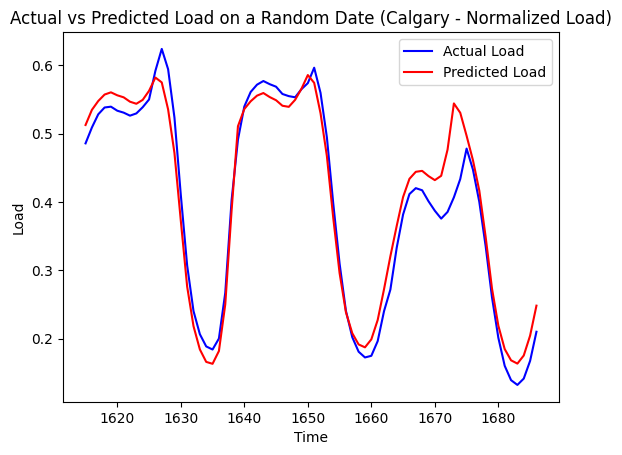

R-squared (r2): 0.9492513867774468
Root Mean Squared Error (RMSE): 0.03418616437000761


In [ ]:
# Plot actual vs. predicted loads for 72 hours ahead
plt.plot(actual_load, label='Actual Load', color='blue')
plt.plot(prediction['Load'], label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual vs Predicted Load on a Random Date (Calgary - Normalized Load)')
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2 = r2_score(actual_load, prediction['Load'])
rmse = np.sqrt(mean_squared_error(actual_load, prediction['Load']))

# Print r2 and rmse
print(f'R-squared (r2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

This was a showcase to compare the efficiency of our previous model with full 24 hours history consideration instead of only the peaks and first preceding data point. Despite the high average accuracy of 99.29% on the validation dataset, we can see that it fails to predict the hours ahead, beyond just a few hours of interest. The 99.29% average accuracy is based on a single point (1 hour in this case) prediction, but the accumulated error grows significantly when the prediction is put in a loop.

**Transfer Learning, Universal Model**

In [ ]:
# Predict on Edmonton set
timeseries_edmonton = fill_timeseries_df(edmonton_normalized_input, edmonton_normalized_output, lag)
edmonton_predictions_rf = rf_model.predict(timeseries_edmonton.drop(columns=['Load']))

# Calculate R^2
edmonton_r2_rf = r2_score(timeseries_edmonton['Load'], edmonton_predictions_rf)

# Calculate RMSE
edmonton_rmse_rf = np.sqrt(mean_squared_error(timeseries_edmonton['Load'], edmonton_predictions_rf))

print("Random Forest with Time Series Features (Ensembling):")
print("Validation RMSE:", edmonton_rmse_rf)
print("Validation R-squared:", edmonton_r2_rf)

Random Forest with Time Series Features (Ensembling):
Validation RMSE: 0.026938915487693844
Validation R-squared: 0.9764825311293965


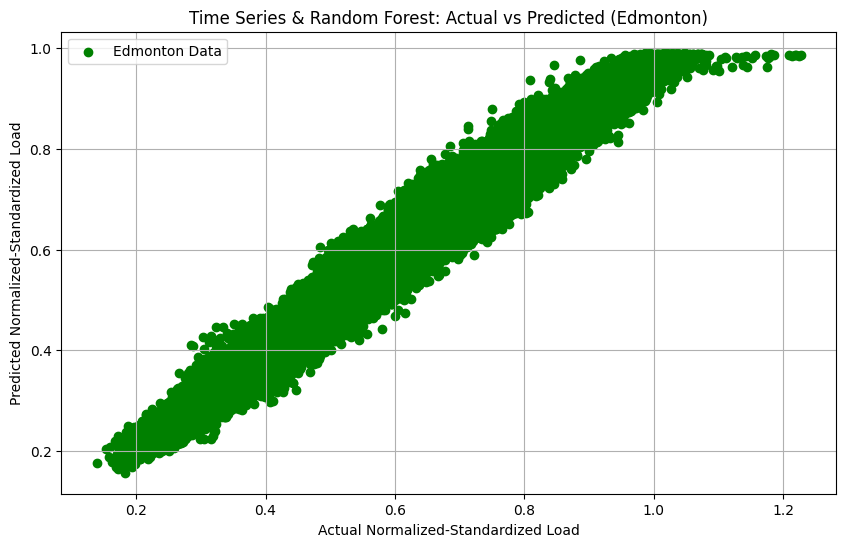

Edmonton RMSE: 0.026938915487693844
Edmonton R-squared: 0.9764825311293965


In [ ]:
# Plot actual vs predicted values for Edmonton set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_edmonton['Load'], edmonton_predictions_rf, color='green', label='Edmonton Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('Time Series & Random Forest: Actual vs Predicted (Edmonton)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for test set
print("Edmonton RMSE:", edmonton_rmse_rf)
print("Edmonton R-squared:", edmonton_r2_rf)

We should remember this plot for the next section. As can be seen in the plot above, a chunk of data towards the tail has actual normalized data above unity while their prediction is below and not more than one. Since the data has been normalized by Calgary train dataset, this is an evidence of higher range of Edmonton's load values than Calgary's. To investigate how much this impacts the transfer learning efficiency, we will develop a model by Edmonton's data and try to predict Calgary's load with it after a more visual plot of how transfer learning from Calgary to Edmonton could predict 72 hours ahead.

In [ ]:
# Prediction of Edmonton by Calgary model
actual_load, random_rows, random_start_index = multiple_prediction(timeseries_edmonton, pred_hr, rf_model)

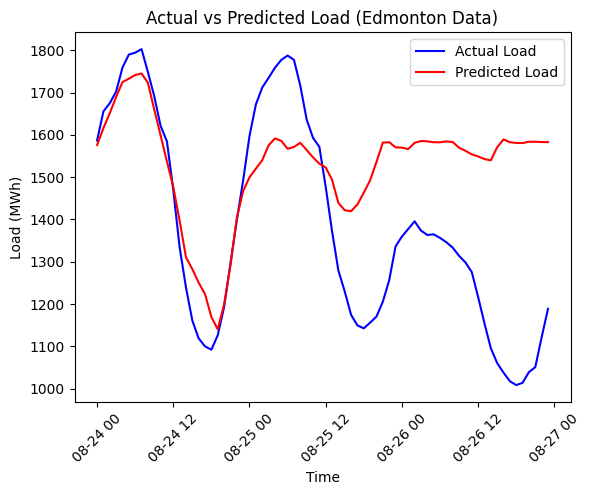

R-squared (r2): -0.0785511370237284
Root Mean Squared Error (RMSE): 0.23443246579133645


In [ ]:
# De-normalize de-standardize the actual and predicted loads
actual_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(actual_load.to_numpy().reshape(-1, 1)))
predicted_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(random_rows['Load'].to_numpy().reshape(-1, 1)))

# Extract the first point of time (timestamp) from Edmonton data
first_point_of_time = edmonton['DATE'][random_start_index + 12]

# Extract the hour from testing_data at the first point of time
first_hour = edmonton['HOUR'][random_start_index + 12]

# Create the x-axis values starting from the first point of time and extending to pred_hr hours more
x_values = pd.date_range(start=first_point_of_time, periods=pred_hr, freq='H')

# Plot actual vs. predicted loads for the hours ahead
plt.plot(x_values, actual_load_denorm, label='Actual Load', color='blue')
plt.plot(x_values, predicted_load_denorm, label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load (MWh)')
plt.title('Actual vs Predicted Load (Edmonton Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2 = r2_score(actual_load, random_rows['Load'])
rmse = np.sqrt(mean_squared_error(actual_load, random_rows['Load']))

# Print r2 and rmse
print(f'R-squared (r2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Prediction of Peace River by Calgary Model

In [ ]:
# Predict on Peace River set
timeseries_peaceriver = fill_timeseries_df(peaceriver_normalized_input, peaceriver_normalized_output, lag)
peaceriver_predictions_rf = rf_model.predict(timeseries_peaceriver.drop(columns=['Load']))

# Calculate R^2
peaceriver_r2_rf = r2_score(timeseries_peaceriver['Load'], peaceriver_predictions_rf)

# Calculate RMSE
peaceriver_rmse_rf = np.sqrt(mean_squared_error(timeseries_peaceriver['Load'], peaceriver_predictions_rf))

print("Random Forest with Time Series Features (Ensembling):")
print("Validation RMSE:", peaceriver_rmse_rf)
print("Validation R-squared:", peaceriver_r2_rf)

Random Forest with Time Series Features (Ensembling):
Validation RMSE: 0.5348145229790029
Validation R-squared: -267.6864777221078


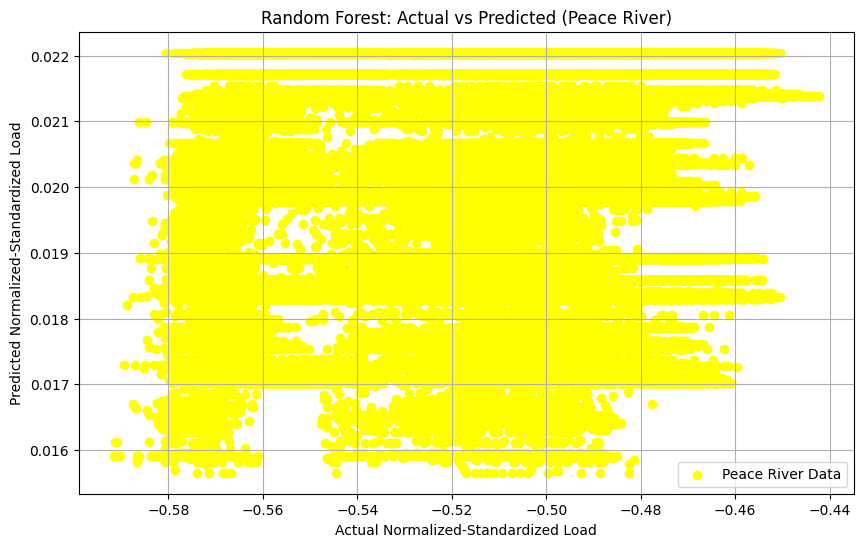

Test RMSE: 0.5348145229790029
Test R-squared: -267.6864777221078


In [ ]:
# Plot actual vs predicted values for Peace River set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_peaceriver['Load'], peaceriver_predictions_rf, color='yellow', label='Peace River Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('Random Forest: Actual vs Predicted (Peace River)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for test set
print("Test RMSE:", peaceriver_rmse_rf)
print("Test R-squared:", peaceriver_r2_rf)

As see above, Calgary model cannot predict Peace River due to completely different correlations of input and output features. This is an example of when and where transfer learning in regression problems can or cannot be applicable.

**Transfer Learning by Edmonton data**

In [ ]:
# Standardize the input features
std_scaler_input = StandardScaler()
edmonton_standardized_input = std_scaler_input.fit_transform(X_edmonton[input_cols])

# Normalize the standardized input features
norm_scaler_input = MinMaxScaler()
edmonton_normalized_input = norm_scaler_input.fit_transform(edmonton_standardized_input)

# Standardize the output vector
std_scaler_output = StandardScaler()
edmonton_standardized_output = std_scaler_output.fit_transform(y_edmonton[output_col])

# Normalize the standardized output vector
norm_scaler_output = MinMaxScaler()
edmonton_normalized_output = norm_scaler_output.fit_transform(edmonton_standardized_output)

In [ ]:
timeseries_edmonton = fill_timeseries_df(edmonton_normalized_input, edmonton_normalized_output, lag)

# Separate input and output features
X = timeseries_edmonton.drop(columns=['Load'])  # Input features (all columns except 'Load', the output feature)
y = timeseries_edmonton['Load']  # Output feature

# Train a Random Forest model
rf_model_edm = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_edm.fit(X, y)

RandomForestRegressor(random_state=42)

Random Forest with Time Series Features (Ensembling):
Validation RMSE: 0.014577827121956464
Validation R-squared: 0.9931137128365354


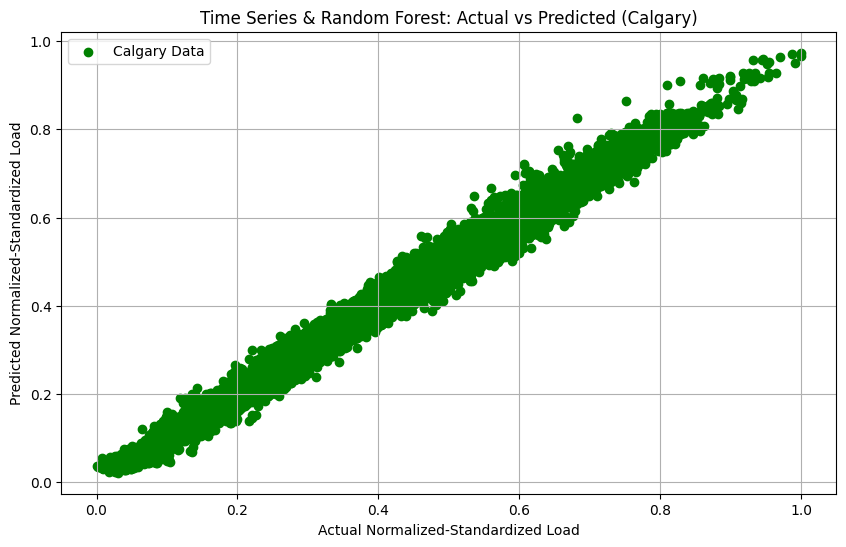

Edmonton RMSE: 0.014577827121956464
Edmonton R-squared: 0.9931137128365354


In [ ]:
# Predict on Calgary set
calgary_predictions_rf = rf_model_edm.predict(timeseries_train.drop(columns=['Load']))

# Calculate R^2
calgary_r2_rf = r2_score(timeseries_train['Load'], calgary_predictions_rf)

# Calculate RMSE
calgary_rmse_rf = np.sqrt(mean_squared_error(timeseries_train['Load'], calgary_predictions_rf))

print("Random Forest with Time Series Features (Ensembling):")
print("Validation RMSE:", calgary_rmse_rf)
print("Validation R-squared:", calgary_r2_rf)

# Plot actual vs predicted values for Edmonton set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_train['Load'], calgary_predictions_rf, color='green', label='Calgary Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('Time Series & Random Forest: Actual vs Predicted (Calgary)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for test set
print("Edmonton RMSE:", calgary_rmse_rf)
print("Edmonton R-squared:", calgary_r2_rf)

As shown above, predicting Calgary load with Edmonton data does not result in underprediction towards the tail; however, it shows a risk of overprediction for a portion of data with normalized load between 0.15 and 0.2.

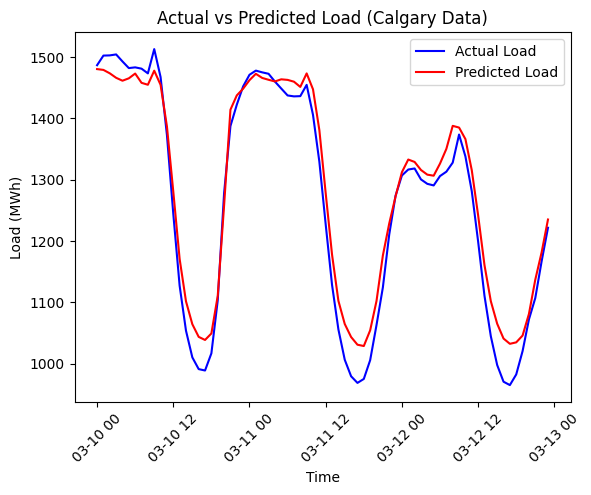

R-squared (r2): 0.9627448968637335
Root Mean Squared Error (RMSE): 0.02995358298729193


In [ ]:
pred_hr = 72

# Prediction of Edmonton by Calgary model
actual_load, random_rows, random_start_index = multiple_prediction(timeseries_train, pred_hr, rf_model_edm)

# De-normalize de-standardize the actual and predicted loads
actual_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(actual_load.to_numpy().reshape(-1, 1)))
predicted_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(random_rows['Load'].to_numpy().reshape(-1, 1)))

# Extract the first point of time (timestamp) from Edmonton data
first_point_of_time = calgary['DATE'][random_start_index + 12]

# Extract the hour from testing_data at the first point of time
first_hour = calgary['HOUR'][random_start_index + 12]

# Create the x-axis values starting from the first point of time and extending to pred_hr hours more
x_values = pd.date_range(start=first_point_of_time, periods=pred_hr, freq='H')

# Plot actual vs. predicted loads for the hours ahead
plt.plot(x_values, actual_load_denorm, label='Actual Load', color='blue')
plt.plot(x_values, predicted_load_denorm, label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load (MWh)')
plt.title('Actual vs Predicted Load (Calgary Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2 = r2_score(actual_load, random_rows['Load'])
rmse = np.sqrt(mean_squared_error(actual_load, random_rows['Load']))

# Print r2 and rmse
print(f'R-squared (r2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

As shown, predicting Calgary load with Edmonton model gives a fairly better accuracy than predicting Edmonton load with Calgary model, especially for the first half a day. This could be the impact of training a model with wider ranges of output data.

**3. Stacking ANN with LSTM**

In [ ]:
# Separate input and output features
X = timeseries_train.drop(columns=['Load']).values
y = timeseries_train['Load'].values
X_valid = timeseries_valid.drop(columns=['Load']).values
y_valid = timeseries_valid['Load'].values

# Define the ANN model architecture
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer with one neuron (for regression task)
])

# Train LSTM model
ann_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = ann_model.fit(X, y, epochs=50, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/50
2145/2145 [==============================] - 8s 3ms/step - loss: 9.3297e-04 - mae: 0.0189 - val_loss: 3.5724e-04 - val_mae: 0.0132
Epoch 2/50
2145/2145 [==============================] - 6s 3ms/step - loss: 2.5784e-04 - mae: 0.0121 - val_loss: 3.2305e-04 - val_mae: 0.0141
Epoch 3/50
2145/2145 [==============================] - 10s 5ms/step - loss: 2.1898e-04 - mae: 0.0111 - val_loss: 2.1691e-04 - val_mae: 0.0103
Epoch 4/50
2145/2145 [==============================] - 10s 5ms/step - loss: 1.9888e-04 - mae: 0.0105 - val_loss: 2.9564e-04 - val_mae: 0.0135
Epoch 5/50
2145/2145 [==============================] - 6s 3ms/step - loss: 1.7920e-04 - mae: 0.0100 - val_loss: 1.8303e-04 - val_mae: 0.0093
Epoch 6/50
2145/2145 [==============================] - 7s 3ms/step - loss: 1.6829e-04 - mae: 0.0097 - val_loss: 1.9847e-04 - val_mae: 0.0098
Epoch 7/50
2145/2145 [==============================] - 6s 3ms/step - loss: 1.5822e-04 - mae: 0.0093 - val_loss: 2.4591e-04 - val_mae: 0.0108
Epoc

821/821 [==============================] - 1s 2ms/step
AN with Time Series Features (Ensembling):
Test RMSE: 0.011262556192336761
Test R-squared: 0.9961737135425098


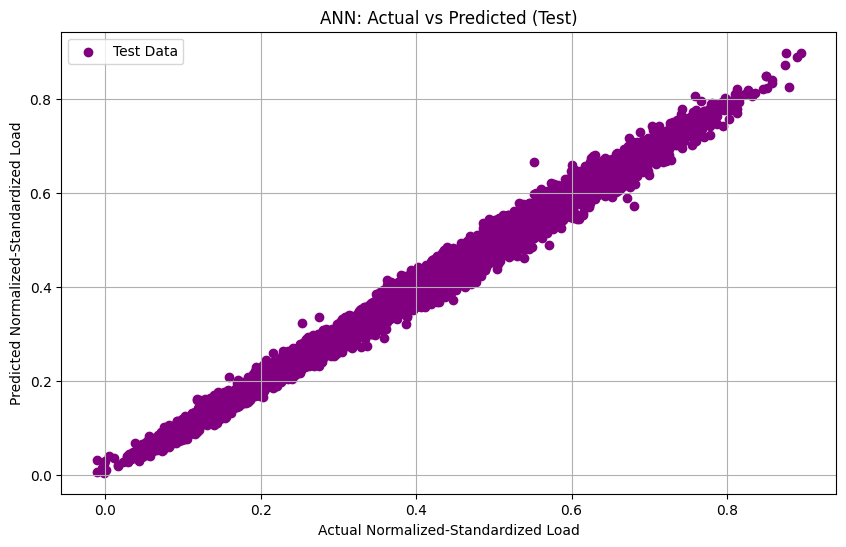

Test RMSE: 0.011262556192336761
Test R-squared: 0.9961737135425098


In [ ]:
# Predict on test set
test_predictions_ann = ann_model.predict(timeseries_test.drop(columns=['Load']))

# Calculate R^2
test_r2_ann = r2_score(timeseries_test['Load'], test_predictions_ann)

# Calculate RMSE
test_rmse_ann = np.sqrt(mean_squared_error(timeseries_test['Load'], test_predictions_ann))

print("AN with Time Series Features (Ensembling):")
print("Test RMSE:", test_rmse_ann)
print("Test R-squared:", test_r2_ann)

# Plot actual vs predicted values for test set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_test['Load'], test_predictions_ann, color='purple', label='Test Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('ANN: Actual vs Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for test set
print("Test RMSE:", test_rmse_ann)
print("Test R-squared:", test_r2_ann)

1/1 [==============================] - 0s 23ms/step


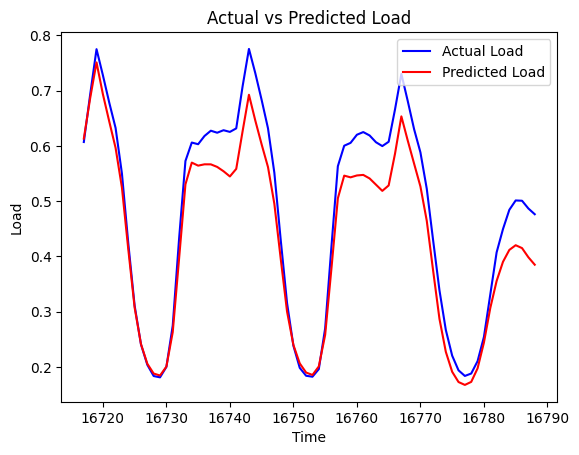

R-squared (r2): 0.9189941270002441
Root Mean Squared Error (RMSE): 0.05320026711836652


In [ ]:
pred_hr = 72
actual_load, prediction, random_start_index = multiple_prediction(timeseries_test, pred_hr, ann_model)

# Plot actual vs. predicted loads for 72 hours ahead
plt.plot(actual_load, label='Actual Load', color='blue')
plt.plot(prediction['Load'], label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual vs Predicted Load')
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2 = r2_score(actual_load, prediction['Load'])
rmse = np.sqrt(mean_squared_error(actual_load, prediction['Load']))

# Print r2 and rmse
print(f'R-squared (r2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

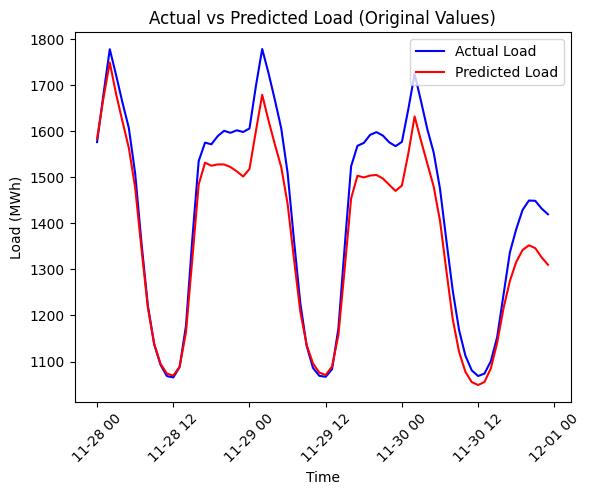

In [ ]:
# De-normalize de-standardize the actual and predicted loads
actual_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(actual_load.to_numpy().reshape(-1, 1)))
predicted_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(prediction['Load'].to_numpy().reshape(-1, 1)))

# Extract the first point of time (timestamp) from testing_data
first_point_of_time = testing_data['DATE'][random_start_index + 12]

# Extract the hour from testing_data at the first point of time
first_hour = testing_data['HOUR'][random_start_index + 12]

# Create the x-axis values starting from the first point of time and extending to pred_hr hours more
x_values = pd.date_range(start=first_point_of_time, periods=pred_hr, freq='H')

# Plot actual vs. predicted loads for the hours ahead
plt.plot(x_values, actual_load_denorm, label='Actual Load', color='blue')
plt.plot(x_values, predicted_load_denorm, label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load (MWh)')
plt.title('Actual vs Predicted Load (Original Values)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

The result shows almost similar accuracy of the previous method (Random Forest). We can see this visually below:

1/1 [==============================] - 0s 35ms/step


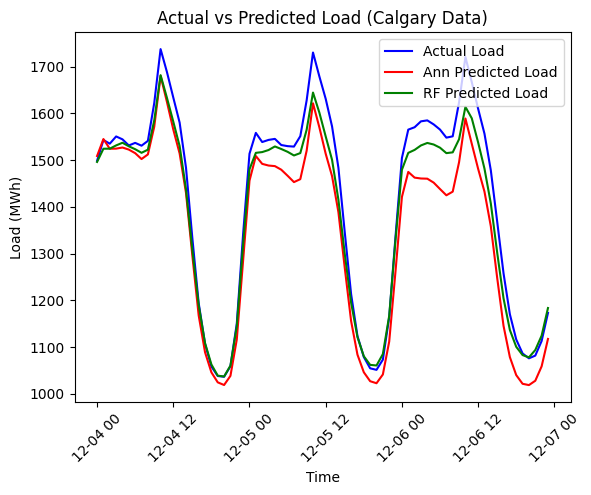

ANN R-squared (r2): 0.8736718219613537
ANN Root Mean Squared Error (RMSE): 0.06471256330476188 MWh
RF R-squared (r2): 0.9637399406528091
RF Root Mean Squared Error (RMSE): 0.03466991219992718 MWh


In [ ]:
# Prediction ANN model
actual_load, prediction_ann, random_start_index = multiple_prediction(timeseries_test, pred_hr, ann_model)

# Prediction by RF model
prediction_rf = timeseries_test.copy().iloc[random_start_index:random_start_index + pred_hr]

for hr in range(pred_hr):
    pred = rf_model.predict(pd.DataFrame(prediction_rf.iloc[hr]).transpose().drop(columns=['Load']))
    prediction_rf['Load'][random_start_index + hr] = pred
    hr_bk = random_start_index + hr
    for future_hr in range(1, lag+1):
            hr_bk = hr_bk + 1
            if hr_bk < random_start_index + pred_hr:
                prediction_rf[f'load {str(future_hr)}hr bk'][hr_bk] = pred

# De-normalize de-standardize the actual and predicted loads
actual_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(actual_load.to_numpy().reshape(-1, 1)))
predicted_ann_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(prediction_ann['Load'].to_numpy().reshape(-1, 1)))
predicted_rf_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(prediction_rf['Load'].to_numpy().reshape(-1, 1)))

# Extract the first point of time
first_point_of_time = calgary['DATE'][random_start_index + 12]

# Extract the hour from testing_data at the first point of time
first_hour = calgary['HOUR'][random_start_index + 12]

# Create the x-axis values starting from the first point of time and extending to pred_hr hours more
x_values = pd.date_range(start=first_point_of_time, periods=pred_hr, freq='H')

# Plot actual vs. predicted loads for the hours ahead
plt.plot(x_values, actual_load_denorm, label='Actual Load', color='blue')
plt.plot(x_values, predicted_ann_load_denorm, label='Ann Predicted Load', color='red')
plt.plot(x_values, predicted_rf_load_denorm, label='RF Predicted Load', color='green')
plt.xlabel('Time')
plt.ylabel('Load (MWh)')
plt.title('Actual vs Predicted Load (Calgary Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2_ann = r2_score(actual_load, prediction_ann['Load'])
rmse_ann = np.sqrt(mean_squared_error(actual_load, prediction_ann['Load']))
r2_rf = r2_score(actual_load, prediction_rf['Load'])
rmse_rf = np.sqrt(mean_squared_error(actual_load, prediction_rf['Load']))

# Print r2 and rmse
print(f'ANN R-squared (r2): {r2_ann}')
print(f'ANN Root Mean Squared Error (RMSE): {rmse_ann} MWh')
print(f'RF R-squared (r2): {r2_rf}')
print(f'RF Root Mean Squared Error (RMSE): {rmse_rf} MWh')

**Is ANN Universal?**

3514/3514 [==============================] - 6s 2ms/step
Ann with Time Series Features (Ensembling):
Validation RMSE: 0.017701082231284554
Validation R-squared: 0.9879686634650345


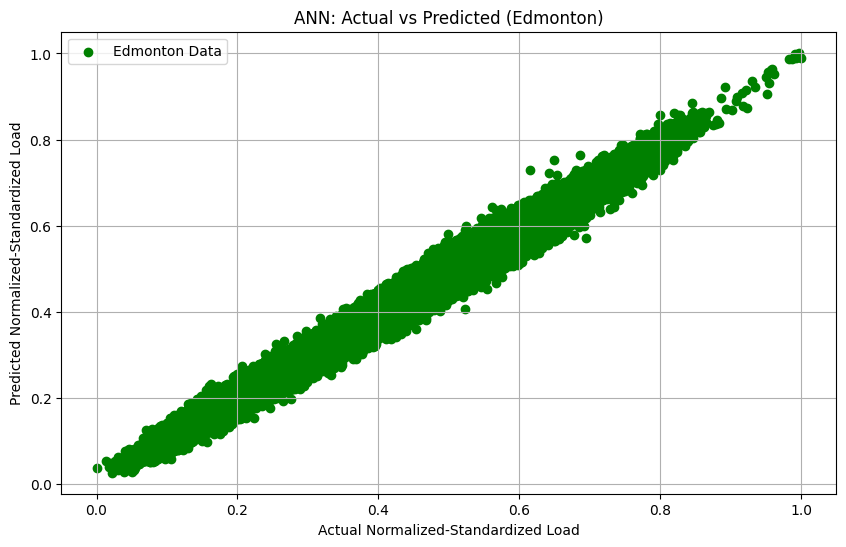

Edmonton RMSE: 0.017701082231284554
Edmonton R-squared: 0.9879686634650345


In [ ]:
# Predict on Edmonton set
edmonton_predictions_ann = ann_model.predict(timeseries_edmonton.drop(columns=['Load']))

# Calculate R^2
edmonton_r2_ann = r2_score(timeseries_edmonton['Load'], edmonton_predictions_ann)

# Calculate RMSE
edmonton_rmse_ann = np.sqrt(mean_squared_error(timeseries_edmonton['Load'], edmonton_predictions_ann))

print("Ann with Time Series Features (Ensembling):")
print("Validation RMSE:", edmonton_rmse_ann)
print("Validation R-squared:", edmonton_r2_ann)

# Plot actual vs predicted values for Edmonton set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_edmonton['Load'], edmonton_predictions_ann, color='green', label='Edmonton Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('ANN: Actual vs Predicted (Edmonton)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for test set
print("Edmonton RMSE:", edmonton_rmse_ann)
print("Edmonton R-squared:", edmonton_r2_ann)

This plot shows an important strength of deep learning ANN. Despite the previous model, Calgary data with ANN could predict loads beyond its original maximum values. **We can consider it as the capability of deep learning to extrapolate** (at least to a certain level).
So, let's try predicting Edmonton load with Calgary data trained by ANN (stacked with time series):

1/1 [==============================] - 0s 28ms/step


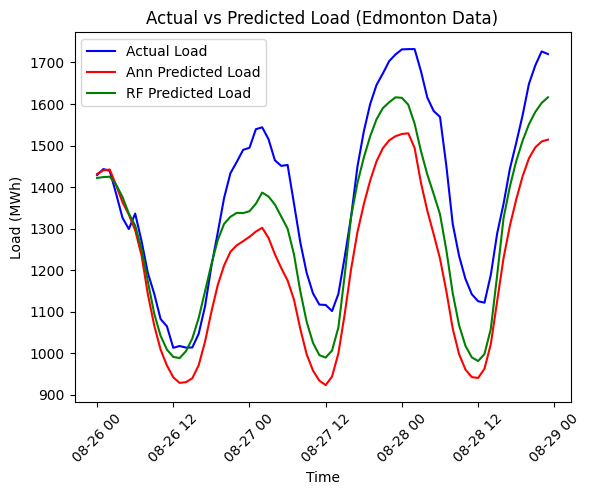

ANN R-squared (r2): 0.31035708218030444
ANN Root Mean Squared Error (RMSE): 0.15039026602529582 MWh
RF R-squared (r2): 0.744993808789161
RF Root Mean Squared Error (RMSE): 0.09144983991267903 MWh


In [ ]:
# Prediction of Edmonton by Calgary model - ANN model
actual_load, prediction_ann, random_start_index = multiple_prediction(timeseries_edmonton, pred_hr, ann_model)

# Prediction of Edmonton by Calgary model - RF model
prediction_rf = timeseries_edmonton.copy().iloc[random_start_index:random_start_index + pred_hr]

for hr in range(pred_hr):
    pred = rf_model.predict(pd.DataFrame(prediction_rf.iloc[hr]).transpose().drop(columns=['Load']))
    prediction_rf['Load'][random_start_index + hr] = pred
    hr_bk = random_start_index + hr
    for future_hr in range(1, lag+1):
            hr_bk = hr_bk + 1
            if hr_bk < random_start_index + pred_hr:
                prediction_rf[f'load {str(future_hr)}hr bk'][hr_bk] = pred

# De-normalize de-standardize the actual and predicted loads
actual_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(actual_load.to_numpy().reshape(-1, 1)))
predicted_ann_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(prediction_ann['Load'].to_numpy().reshape(-1, 1)))
predicted_rf_load_denorm = std_scaler_output.inverse_transform(norm_scaler_output.inverse_transform(prediction_rf['Load'].to_numpy().reshape(-1, 1)))

# Extract the first point of time (timestamp) from Edmonton data
first_point_of_time = edmonton['DATE'][random_start_index + 12]

# Extract the hour from testing_data at the first point of time
first_hour = edmonton['HOUR'][random_start_index + 12]

# Create the x-axis values starting from the first point of time and extending to pred_hr hours more
x_values = pd.date_range(start=first_point_of_time, periods=pred_hr, freq='H')

# Plot actual vs. predicted loads for the hours ahead
plt.plot(x_values, actual_load_denorm, label='Actual Load', color='blue')
plt.plot(x_values, predicted_ann_load_denorm, label='Ann Predicted Load', color='red')
plt.plot(x_values, predicted_rf_load_denorm, label='RF Predicted Load', color='green')
plt.xlabel('Time')
plt.ylabel('Load (MWh)')
plt.title('Actual vs Predicted Load (Edmonton Data)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2_ann = r2_score(actual_load, prediction_ann['Load'])
rmse_ann = np.sqrt(mean_squared_error(actual_load, prediction_ann['Load']))
r2_rf = r2_score(actual_load, prediction_rf['Load'])
rmse_rf = np.sqrt(mean_squared_error(actual_load, prediction_rf['Load']))

# Print r2 and rmse
print(f'ANN R-squared (r2): {r2_ann}')
print(f'ANN Root Mean Squared Error (RMSE): {rmse_ann} MWh')
print(f'RF R-squared (r2): {r2_rf}')
print(f'RF Root Mean Squared Error (RMSE): {rmse_rf} MWh')

As can be seen, both models offer similar accuracy level. Repeating this snippet to repeat it with several random dates, one could see the same competitive behaviour. However, due to more flexibility of ANN to extrapolate, a stronger prediction by ANN-Timeseries could be expected for the higher end values that are beyond Calgary load maximum value.

The last trial with deterministic modelling is training ANN-Timeseries model by Edmonton data and evaluation of its performance to predict Calgary load:

**ANN with Edmonton Data**

In [ ]:
# Split the data into training and validation sets
training_data_edm = edmonton[(edmonton['DATE'].dt.year >= 2013)]
validation_edm = edmonton[(edmonton['DATE'].dt.year.isin([2011, 2012]))]

training_data_edm = training_data_edm.drop(columns=['DATE'])
validation_edm = validation_edm.drop(columns=['DATE'])

X_train_edm = training_data_edm.drop(columns=['Load'])
y_train_edm = training_data_edm['Load']
X_validation_edm = validation_edm.drop(columns=['Load'])
y_validation_edm = validation_edm['Load']

# Extract input and output names
input_cols = X_train_edm.columns

# Standardize the input features
std_scaler_input = StandardScaler()

# Fit and transform input features for training set (Standardization)
train_edm_standardized_input = std_scaler_input.fit_transform(X_train_edm[input_cols])

# Transform input features for validation sets (Standardization)
validation_edm_standardized_input = std_scaler_input.transform(X_validation_edm[input_cols])

# Normalize the standardized input features
norm_scaler_input = MinMaxScaler()

# Fit and transform input features for training set (Normalization)
train_edm_normalized_input = norm_scaler_input.fit_transform(train_edm_standardized_input)

# Transform input features for validation sets (Normalization)
validation_edm_normalized_input = norm_scaler_input.transform(validation_edm_standardized_input)

In [ ]:
# Standardize the output features
std_scaler_output = StandardScaler()

# Fit and transform output features for training set (Standardization)
train_edm_standardized_output = std_scaler_output.fit_transform(pd.DataFrame(y_train_edm))

# Transform output features for validation sets (Standardization)
validation_edm_standardized_output = std_scaler_output.transform(pd.DataFrame(y_validation_edm))

# Normalize the standardized output features
norm_scaler_output = MinMaxScaler()

# Fit and transform output features for training set (Normalization)
train_edm_normalized_output = norm_scaler_output.fit_transform(train_edm_standardized_output)

# Transform output features for validation sets (Normalization)
validation_edm_normalized_output = norm_scaler_output.transform(validation_edm_standardized_output)

In [ ]:
# Columns to build the timeseries dataframes
input_cols = input_cols.tolist()

In [ ]:
timeseries_train_edm = fill_timeseries_df(train_edm_normalized_input, train_edm_normalized_output, lag)
timeseries_valid_edm = fill_timeseries_df(validation_edm_normalized_input, validation_edm_normalized_output, lag)

In [ ]:
# Separate input and output features
X = timeseries_train_edm.drop(columns=['Load']).values
y = timeseries_train_edm['Load'].values
X_valid = timeseries_valid_edm.drop(columns=['Load']).values
y_valid = timeseries_valid_edm['Load'].values

# Define the ANN model architecture
ann_model_edm = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer with one neuron (for regression task)
])

# Train LSTM model
ann_model_edm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = ann_model_edm.fit(X, y, epochs=50, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/50
2966/2966 [==============================] - 12s 4ms/step - loss: 0.0013 - mae: 0.0210 - val_loss: 4.4978e-04 - val_mae: 0.0165
Epoch 2/50
2966/2966 [==============================] - 10s 3ms/step - loss: 3.7673e-04 - mae: 0.0150 - val_loss: 3.3739e-04 - val_mae: 0.0141
Epoch 3/50
2966/2966 [==============================] - 9s 3ms/step - loss: 3.4612e-04 - mae: 0.0143 - val_loss: 3.2302e-04 - val_mae: 0.0135
Epoch 4/50
2966/2966 [==============================] - 10s 3ms/step - loss: 3.2574e-04 - mae: 0.0139 - val_loss: 2.7854e-04 - val_mae: 0.0125
Epoch 5/50
2966/2966 [==============================] - 9s 3ms/step - loss: 3.0551e-04 - mae: 0.0134 - val_loss: 2.6014e-04 - val_mae: 0.0122
Epoch 6/50
2966/2966 [==============================] - 9s 3ms/step - loss: 2.9836e-04 - mae: 0.0133 - val_loss: 3.7931e-04 - val_mae: 0.0159
Epoch 7/50
2966/2966 [==============================] - 11s 4ms/step - loss: 2.9478e-04 - mae: 0.0132 - val_loss: 2.8198e-04 - val_mae: 0.0131
Epoch 

2145/2145 [==============================] - 4s 2ms/step
ANN with Time Series Features (Ensembling):
Validation RMSE: 0.014004042155256899
Validation R-squared: 0.9936438199657502


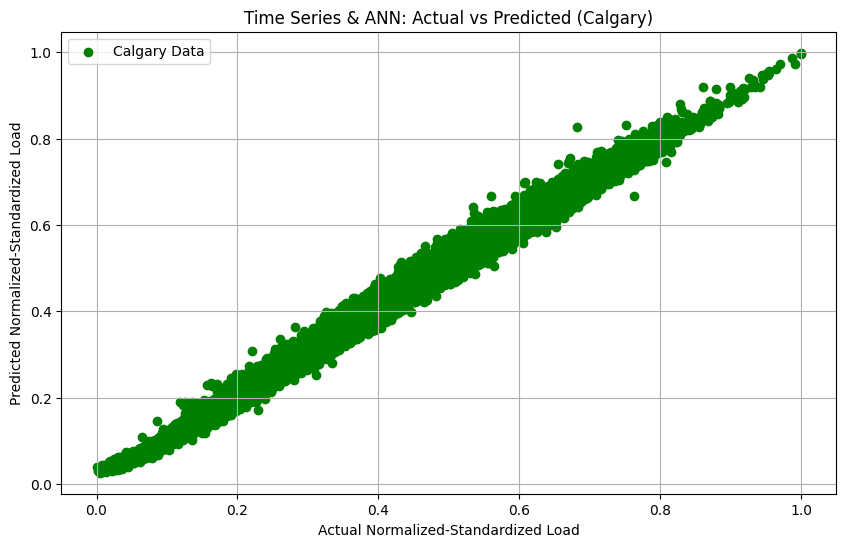

Edmonton RMSE: 0.014004042155256899
Edmonton R-squared: 0.9936438199657502


In [ ]:
# Predict on Calgary set
calgary_predictions_ann = ann_model_edm.predict(timeseries_train.drop(columns=['Load']))

# Calculate R^2
calgary_r2_ann = r2_score(timeseries_train['Load'], calgary_predictions_ann)

# Calculate RMSE
calgary_rmse_ann = np.sqrt(mean_squared_error(timeseries_train['Load'], calgary_predictions_ann))

print("ANN with Time Series Features (Ensembling):")
print("Validation RMSE:", calgary_rmse_ann)
print("Validation R-squared:", calgary_r2_ann)

# Plot actual vs predicted values for Edmonton set
plt.figure(figsize=(10, 6))
plt.scatter(timeseries_train['Load'], calgary_predictions_ann, color='green', label='Calgary Data')
plt.xlabel('Actual Normalized-Standardized Load')
plt.ylabel('Predicted Normalized-Standardized Load')
plt.title('Time Series & ANN: Actual vs Predicted (Calgary)')
plt.legend()
plt.grid(True)
plt.show()

# Print RMSE and R-squared for test set
print("Edmonton RMSE:", calgary_rmse_ann)
print("Edmonton R-squared:", calgary_r2_ann)

In [ ]:
pred_hr = 72
actual_load, prediction, random_start_index = multiple_prediction(timeseries_test, pred_hr, ann_model_edm)

# Plot actual vs. predicted loads for 72 hours ahead
plt.plot(actual_load, label='Actual Load', color='blue')
plt.plot(prediction['Load'], label='Predicted Load', color='red')
plt.xlabel('Time')
plt.ylabel('Load')
plt.title('Actual vs Predicted Load (Calgary Data - Normalized)')
plt.legend()
plt.show()

# Calculate R-squared (r2) and Root Mean Squared Error (RMSE)
r2 = r2_score(actual_load, prediction['Load'])
rmse = np.sqrt(mean_squared_error(actual_load, prediction['Load']))

# Print r2 and rmse
print(f'R-squared (r2): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

It can be seen that when a more inclusive data is used to train, ANN-Timeseries model offers a more robust prediction than -RF. The evidence is the prediction of Calgary load by Edmonton model when ANN-Timeseries is compared with RF-Timeseries.

**4. Probabilistic Analysis**

Probabilistic analysis quantifies uncertainty in predictions through probability distributions. It's particularly useful for load forecasting as it provides not only point estimates but also prediction intervals, allowing decision-makers to understand the range of potential outcomes and associated probabilities. This enables better risk management and decision-making in scenarios where uncertainty plays a crucial role, such as load forecasting for energy grid management.

GluonTS is an open-source toolkit for probabilistic time series forecasting, offering flexible and scalable implementations of state-of-the-art models along with utilities for model evaluation and deployment.

In [ ]:
# pip install gluont
# pip install mxnet gluonts
# pip install --upgrade numpy

import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.mx import Trainer, GPVAREstimator
from gluonts.mx.trainer.callback import TrainingHistory

In [ ]:
# Convert 'DATE' column to datetime format
calgary['DATE'] = pd.to_datetime(calgary['DATE'])

# Add the hours to the 'DATE' column
calgary['DATE'] = calgary['DATE'] + pd.to_timedelta(calgary['HOUR'].astype(str).str.zfill(2) + ':00:00')

Gluonts fails if missing or duplicated dates are available. So, we need to check and handle this.

In [ ]:
# Check for missing timestamps
missing_timestamps = pd.date_range(start=calgary['DATE'].min(), end=calgary['DATE'].max(), freq='H').difference(calgary['DATE'])
print("Missing timestamps:", missing_timestamps)

# Check for duplicate timestamps
duplicate_timestamps = calgary[calgary.duplicated('DATE')]
print("Duplicate timestamps:", duplicate_timestamps)

In [ ]:
# Generate a complete range of timestamps
complete_range = pd.date_range(start=calgary['DATE'].min(), end=calgary['DATE'].max(), freq='H')

# Create a new DataFrame with the complete range of timestamps
complete_df = pd.DataFrame({'DATE': complete_range})

# Merge the original DataFrame with the complete DataFrame on 'DATE'
calgary = pd.merge(complete_df, calgary, on='DATE', how='left')

# Interpolate missing values in 'Calgary Load' column
calgary['Load'] = calgary['Load'].interpolate(method='linear')

# Interpolate missing values in other columns
calgary['HOUR'] = calgary['DATE'].dt.hour
calgary['WORKING'] = calgary['HOUR'].apply(lambda hour: 1 if hour in [9, 10, 11, 12, 13, 14, 15, 16] else 0)
calgary['temp'] = calgary['temp'].interpolate(method='linear')
calgary['relHum'] = calgary['relHum'].interpolate(method='linear')

Gluonts need an item_id to be able to start modelling. The reason is that it could model multiple trend (for different items) at the same time using a single dataframe.

In [ ]:
calgary['item_id'] = 'calgary'

In [ ]:
train = calgary.loc[calgary['DATE'].dt.year <= 2018]
valid = calgary.loc[(calgary['DATE'].dt.year >= 2019) & (calgary['DATE'].dt.year <= 2020)]
num_ts_train = len(train)
num_ts_val = len(valid)

In [ ]:
unique_series = train['item_id'].nunique()
train_ds = PandasDataset.from_long_dataframe(train, target='Load', item_id='item_id', timestamp='DATE', freq='H')
grouper_train = MultivariateGrouper(max_target_dim=unique_series)
train_ds = grouper_train(train_ds)

(context_length is the depth of the time series that we want to use for training)

In [ ]:
# defining a callback, which will log the training loss for each epoch
history = TrainingHistory()

estimator = GPVAREstimator(freq='H', prediction_length=72, #72 hrs prediction
                           target_dim=unique_series,
                           context_length=lag,
                           trainer = Trainer(ctx='cpu', epochs=50, learning_rate=1e-2, callbacks=[history]))
predictor = estimator.train(train_ds)

(Note: The run was stopped manually to save time when no sensible improvements were seen.)

In [ ]:
print(history.loss_history)

In [ ]:
# Specify the file path to save the trained predictor
file_path = aeso_data_dir + '/models/Gluonts_predictor_joblib.pkl'

# Save the trained predictor using joblib
joblib.dump(predictor, file_path)

In [ ]:
# Specify the file path to save the trained predictor
file_path = aeso_data_dir + '/models/Gluonts_predictor_pkl.pkl'

# Save the trained predictor using pickle
with open(file_path, 'wb') as f:
    pickle.dump(predictor, f)

In [ ]:
# Load the saved predictor using joblib
predictor = joblib.load(aeso_data_dir + '/models/Gluonts_predictor_joblib.pkl')

In [ ]:
unique_series_val = valid['item_id'].nunique()
valid_ds = PandasDataset.from_long_dataframe(valid, target='Load', item_id='item_id', timestamp='DATE', freq='H')
grouper_train = MultivariateGrouper(max_target_dim=unique_series_val)
valid_ds = grouper_train(valid_ds)

In [ ]:
pred = list(predictor.predict(valid_ds))

In [ ]:
test = calgary.loc[calgary['DATE'].dt.year >= 2021]

In [ ]:
all_preds = list()
item = pred[0]
p = np.median(item.samples, axis=0).clip(0)
p10 = np.percentile(item.samples, 10, axis=0).clip(0)
p90 = np.percentile(item.samples, 90, axis=0).clip(0)
dates = pd.date_range(start=item.start_date.to_timestamp(), periods=len(p), freq='H')

for name, q in [('p50', p), ('p10', p10), ('p90', p90)]:
    wide_p = pd.DataFrame({'DATE': dates})
    for i, city in enumerate(valid['item_id'].unique()):
        wide_p[city] = q[:, i]
    wide_p = wide_p.melt(id_vars='DATE', var_name='item_id', value_name=name)
    all_preds.append(wide_p.set_index(['DATE', 'item_id']))

all_preds = pd.concat(all_preds, axis=1).reset_index()
all_preds = all_preds.merge(test, on=['DATE'], how='left')

In [ ]:
# Plot actual load and mean prediction
plt.figure(figsize=(10, 6))

# Plot actual load
plt.plot(all_preds['DATE'], all_preds['Load'], color='blue', label='Actual Load')

# Plot mean prediction (p50)
plt.plot(all_preds['DATE'], all_preds['p50'], color='red', label='Mean Prediction')

# Fill between p10 and p90
plt.fill_between(all_preds['DATE'], all_preds['p10'], all_preds['p90'], color='gray', alpha=0.3, label='Prediction Range (p10 to p90)')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual Load vs Mean Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

Our probabilistic model is not optimized yet and is our future work. In this project, we decided to just showcase its capability for the cases like load prediction where the operators like to have an understanding of uncertainty and a range of most possible potential values. The parameters that can be used to improve this model include:

In [ ]:
# Define hyperparameters
hyperparameters = {
    'freq': 'H',                           # Frequency of the time series data
    'prediction_length': 72,               # Number of time steps to predict into the future
    'target_dim': unique_series,          # Dimensionality of the target variable
    'context_length': 8,                   # Length of the context window for the model
    'num_layers': 2,                       # Number of layers in the model architecture
    'num_cells': 40,                       # Number of cells in each layer of the model
    'dropout_rate': 0.1,                   # Dropout rate to apply between layers
    'embedding_dimension': None,           # Dimensionality of the embeddings for categorical features
    'use_feat_static_cat': False,          # Whether to use static categorical features in the model
    'cardinality': None,                   # Number of categories in static categorical features
    'distr_output': None,                  # Distributional output of the model
    'scaling': True,                       # Whether to apply scaling to the target variable
    'batch_size': 32,                      # Size of the batches used during training
    'epochs': 100,                         # Number of epochs for training
    'learning_rate': 1e-3,                 # Learning rate for the optimizer
    'learning_rate_decay_factor': 0.5,     # Factor by which to decay the learning rate during training
    'clip_gradient': 10.0,                 # Maximum gradient norm for gradient clipping
    'weight_decay': 1e-5,                  # Weight decay (L2 regularization) coefficient
    'num_parallel_samples': 100,           # Number of samples to draw in parallel during inference
    'max_idle_network': 10,                # Maximum number of epochs without improvement in validation loss before early stopping
    'hybridize_prediction_net': True,      # Whether to hybridize the prediction network for faster execution
    'hybridize_input_net': True            # Whether to hybridize the input network for faster execution
}

Since we uninstalled numpy at the beginning and installed a specific version of it (due to some legacy requirement by Gluonts), let's upgrade numpy in the end.

In [ ]:
!pip install numpy --upgrade